# Лабораторная работа №1: KNN

## 1. Выбор начальных условий

### a. Задача классификации

**Датасет**: IBM HR Analytics Employee Attrition & Performance  
**Обоснование**: Датасет представляет реальную практическую задачу прогнозирования текучести кадров (employee attrition) в компании. Актуальность задачи заключается в ее высокой практической и экономической значимости для любой крупной организации. Добровольное увольнение ценных сотрудников ведет к прямым финансовым потерям (стоимость найма и адаптации нового сотрудника), снижению производительности, потере знаний и опыта.

### b. Задача регрессии

**Датасет**: House Sales in King County, USA  
**Обоснование**: Классическая и крайне важная практическая задача прогнозирования рыночной стоимости недвижимости. Практическая ценность этой задачи огромна для всех участников рынка недвижимости: для продавцов и покупателей при определении справедливой цены, для риелторов и агентств при оценке предложений, для банков и страховых компаний при оценке залоговой стоимости и рисков, а также для инвесторов.

### c. Метрики качества

**Классификация**

**Основная метрика**: F1-score
Дает единый сбалансированный показатель для сравнения моделей в условиях дисбаланса классов (увольнения редки).

**Вспомогательные метрики**:

1. Precision (Точность)
Показывает долю верно предсказанных увольнений среди всех срабатываний модели. Критична для оценки эффективности использования ресурсов HR (чтобы не тратить время на ложные тревоги). Без нее мы не поймем, сколько усилий тратится впустую.

2. Recall (Полнота)
Показывает долю реальных увольнений, которые модель смогла обнаружить. Критична для минимизации потерь компании (чтобы не пропустить уход ключевых специалистов). Без нее мы не поймем, сколько увольнений осталось незамеченными.

3. Confusion Matrix (Матрица ошибок)
Зачем: Наглядно показывает количество четырех типов предсказаний (TP, FP, TN, FN). Необходима для понимания природы ошибок модели и расчета precision/recall.

Я не буду использовать ROC-AUC, тк он будет вводить в заблуждение на дисбалансированных данных (в датасете 84 на 16)

**Регрессия**

**Основная метрика**: RMSE (Root Mean Square Error)
Показывает среднеквадратичную ошибку в долларах, сильно штрафуя за крупные ошибки (что критично в недвижимости, где ошибка в $100K значительнее, чем в $10K). Без нее сложно оценить реальную масштабность ошибок модели.

**Вспомогательные метрики**:

1. MAPE (Mean Absolute Percentage Error)
Показывает среднюю ошибку в процентах. Незаменима для отчетности перед бизнесом ("модель ошибается в среднем на 12%") и сравнения с другими решениями. Без нее сложно оценить относительную точность модели.

2. R² (Коэффициент детерминации)
Показывает, какую долю дисперсии цены объясняют выбранные признаки. Дает общее представление об адекватности модели (R²=0.8 → модель объясняет 80% колебаний цены). Без нее трудно оценить, насколько хороша модель в принципе.

3. MAE (Mean Absolute Percentage Error)
Показывает среднюю величину ошибки в долларах. Более устойчива к выбросам, чем RMSE, и дает интуитивно понятное представление о средней точности прогноза 

### Загрузка библиотек и настройка визуализации

In [1]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score,
                           mean_squared_error, mean_absolute_error,
                           r2_score, mean_absolute_percentage_error)

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 12
sns.set_palette("husl")

### Загрузка и анализ датасета для Классификации (Employee Attrition)

Датасет загружен: 1470 строк, 35 столбцов

--- 1.1 Первичный обзор данных ---
Первые 5 строк датасета:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical       

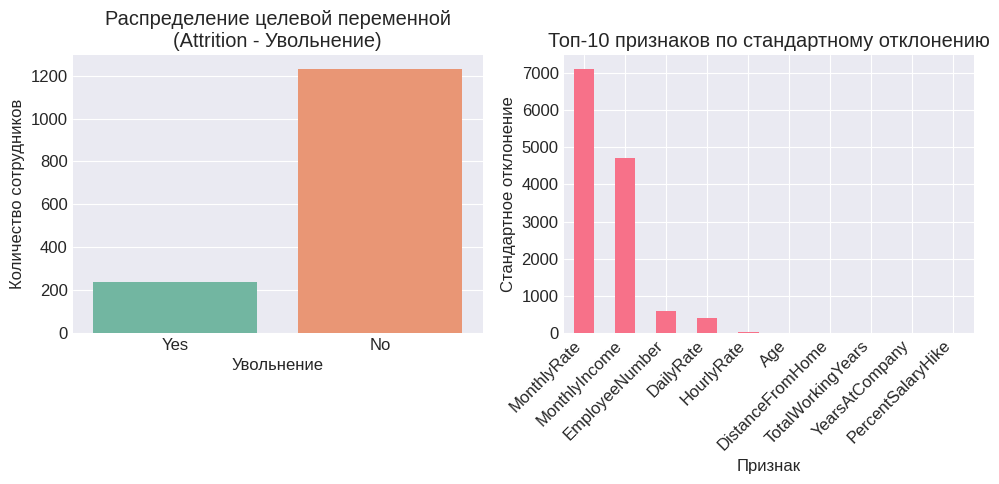


--- 1.7 Корреляционный анализ с целевой переменной ---
Топ-10 признаков по абсолютной корреляции с целевой переменной:
TotalWorkingYears       0.171063
JobLevel                0.169105
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
YearsAtCompany          0.134392
JobInvolvement          0.130016
JobSatisfaction         0.103481
dtype: float64


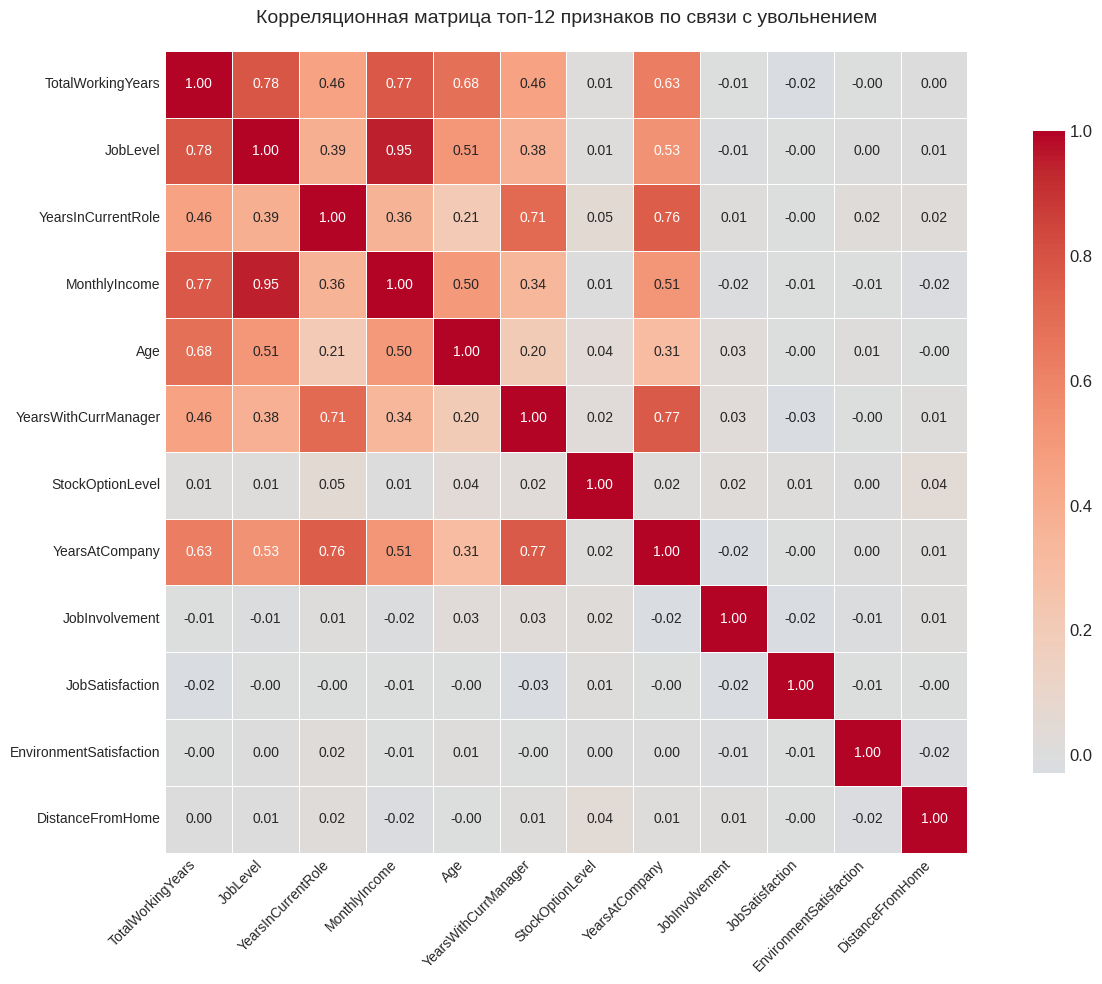

In [3]:
# Ячейка 1: АНАЛИЗ ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ - ПРОГНОЗ УВОЛЬНЕНИЙ
# Загрузка датасета
df_class = pd.read_csv('Classification.csv')
print(f"Датасет загружен: {df_class.shape[0]} строк, {df_class.shape[1]} столбцов")

# 1.1 Первичный обзор данных
print("\n--- 1.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_class.head())
print("\nИнформация о типах данных:")
print(df_class.info())

# 1.2 Статистическое описание числовых признаков
print("\n--- 1.2 Статистическое описание числовых признаков ---")
print(df_class.describe())

# 1.3 Проверка пропущенных значений
print("\n--- 1.3 Проверка пропущенных значений ---")
missing_values = df_class.isnull().sum()
missing_percent = (missing_values / len(df_class)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
}).sort_values('Количество пропусков', ascending=False)

print(missing_df[missing_df['Количество пропусков'] > 0])
if missing_df[missing_df['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 1.4 Анализ целевой переменной (Attrition)
print("\n--- 1.4 Анализ целевой переменной (Attrition) ---")
target_counts = df_class['Attrition'].value_counts()
target_percent = df_class['Attrition'].value_counts(normalize=True) * 100

print(f"Распределение классов:\n{target_counts}")
print(f"\nПроцентное соотношение:\n{target_percent.round(2)}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_class, x='Attrition', palette='Set2')
plt.title('Распределение целевой переменной\n(Attrition - Увольнение)')
plt.xlabel('Увольнение')
plt.ylabel('Количество сотрудников')

# 1.5 Анализ категориальных признаков
print("\n--- 1.5 Анализ категориальных признаков ---")
categorical_cols = df_class.select_dtypes(include=['object']).columns
print(f"Найдено категориальных признаков: {len(categorical_cols)}")

for col in categorical_cols:
    unique_vals = df_class[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# 1.6 Анализ стандартных отклонений числовых признаков
print("\n--- 1.6 Анализ стандартных отклонений числовых признаков ---")
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
std_dev = df_class[numeric_cols].std()

std_df = pd.DataFrame({
    'Стандартное отклонение': std_dev,
    'Среднее значение': df_class[numeric_cols].mean(),
    'Коэффициент вариации': (std_dev / df_class[numeric_cols].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df.head(10))

# Визуализация стандартных отклонений
plt.subplot(1, 2, 2)
std_df.head(10)['Стандартное отклонение'].plot(kind='bar')
plt.title('Топ-10 признаков по стандартному отклонению')
plt.xlabel('Признак')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.7 Корреляционный анализ с целевой переменной
print("\n--- 1.7 Корреляционный анализ с целевой переменной ---")
# Преобразование целевой переменной в числовой формат для корреляции
df_class['Attrition_numeric'] = df_class['Attrition'].map({'Yes': 1, 'No': 0})
correlations = df_class[numeric_cols].corrwith(df_class['Attrition_numeric']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с целевой переменной:")
print(correlations.head(10))

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
top_corr_features = correlations.head(12).index
corr_matrix = df_class[top_corr_features].corr()

# Настройка размера шрифта и формата чисел
annot_kws = {"size": 10, "weight": "normal"}
fmt = '.2f'  # Формат отображения чисел (2 знака после запятой)

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=fmt,
                     cmap='coolwarm', 
                     center=0, 
                     square=True, 
                     linewidths=0.5,
                     cbar_kws={"shrink": 0.8},
                     annot_kws=annot_kws)

# Настройка подписей осей
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Корреляционная матрица топ-12 признаков по связи с увольнением', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Загрузка и анализ датасета для Регрессии (House Sales)

Датасет загружен: 21613 строк, 21 столбцов

--- 2.1 Первичный обзор данных ---
Первые 5 строк датасета:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0        

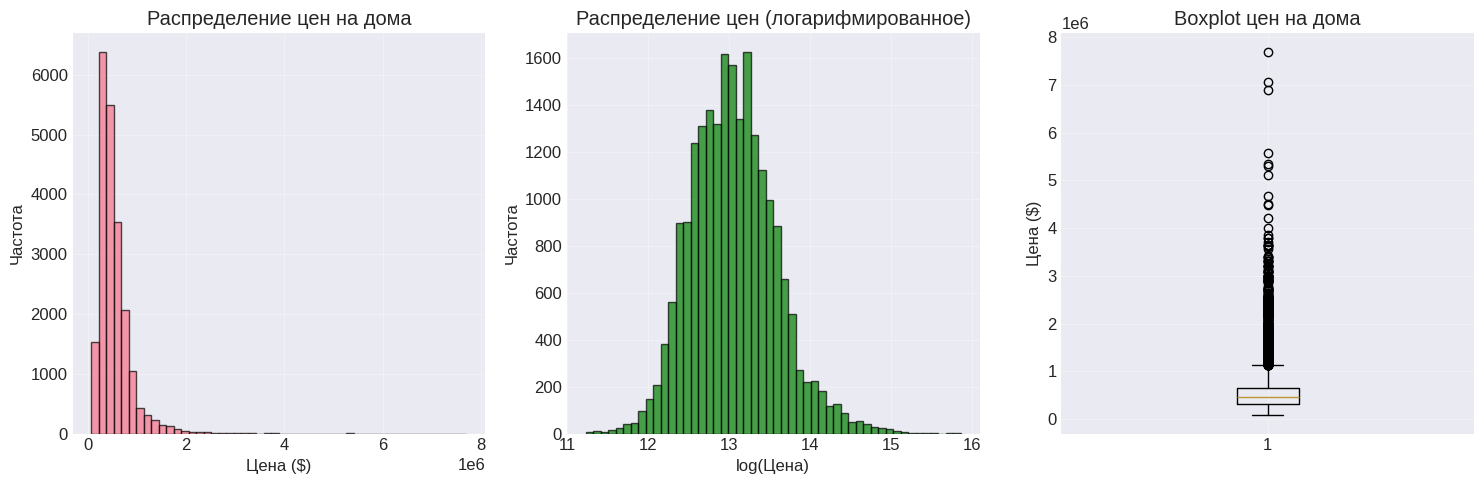


--- 2.5 Анализ стандартных отклонений ---
Топ-10 признаков с наибольшим стандартным отклонением:
               Стандартное отклонение  Среднее значение  Коэффициент вариации
id                       2.876566e+09      4.580302e+09                 62.80
price                    3.671272e+05      5.400881e+05                 67.98
sqft_lot                 4.142051e+04      1.510697e+04                274.18
sqft_lot15               2.730418e+04      1.276846e+04                213.84
sqft_living              9.184409e+02      2.079900e+03                 44.16
sqft_above               8.280910e+02      1.788391e+03                 46.30
sqft_living15            6.853913e+02      1.986552e+03                 34.50
sqft_basement            4.425750e+02      2.915090e+02                151.82
yr_renovated             4.016792e+02      8.440226e+01                475.91
zipcode                  5.350503e+01      9.807794e+04                  0.05

--- 2.6 Корреляция с целевой переменной (pr

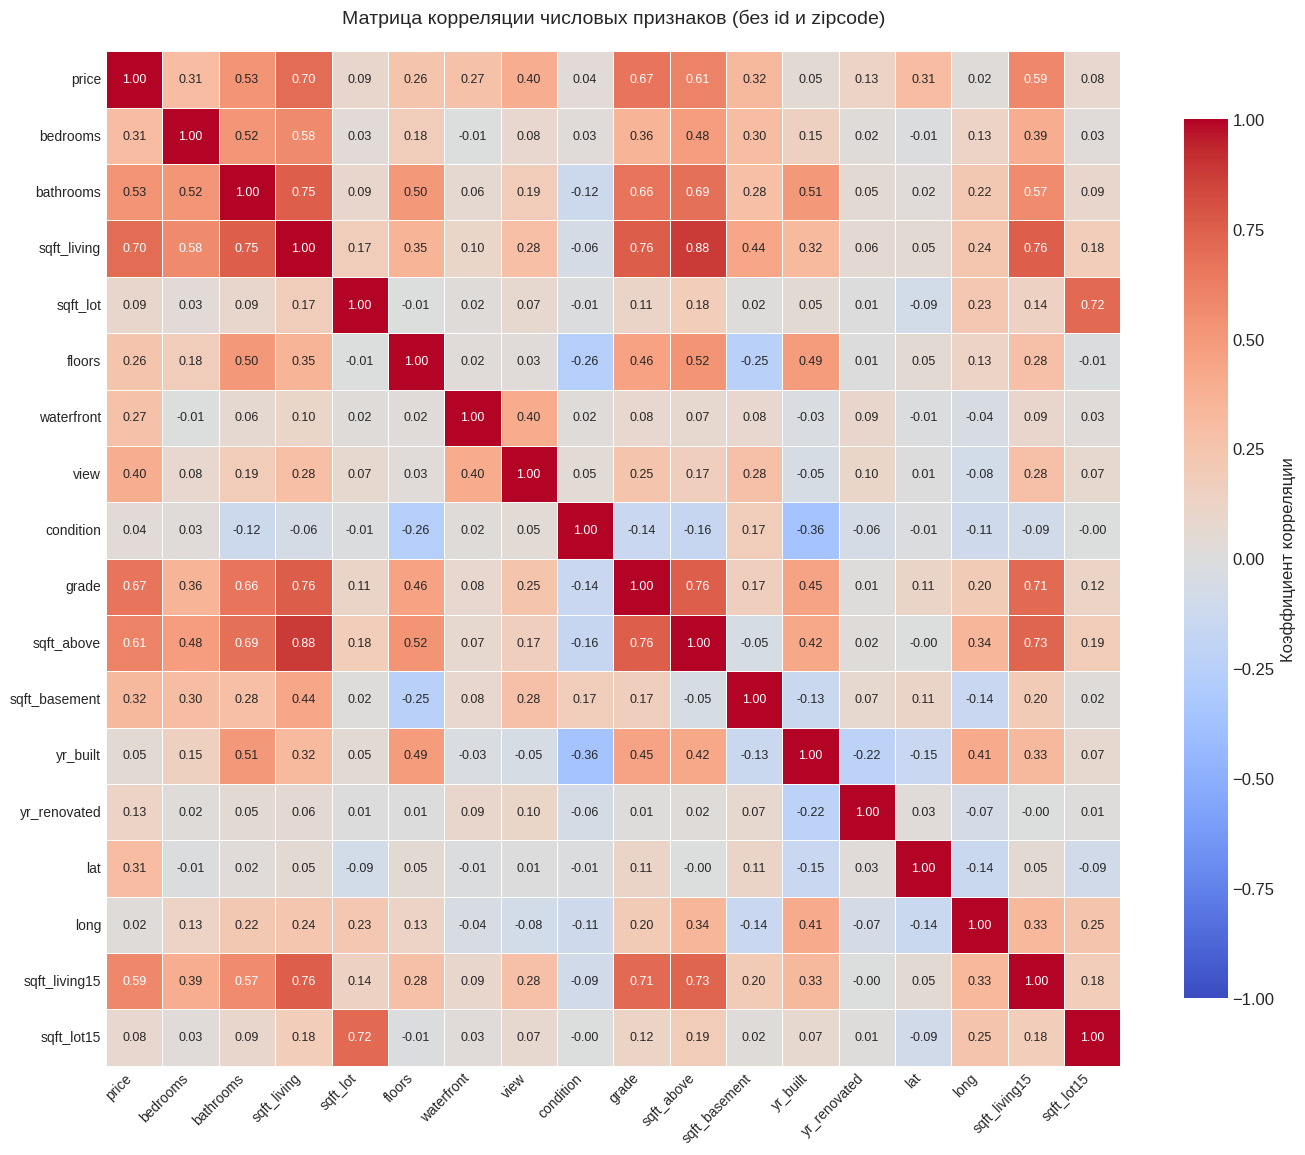


--- Анализ наиболее коррелирующих признаков ---
Пары признаков с высокой корреляцией (|r| > 0.7):
------------------------------------------------------------
  sqft_living     и sqft_above      => 0.877
  sqft_living     и grade           => 0.763
  sqft_living     и sqft_living15   => 0.756
  grade           и sqft_above      => 0.756
  bathrooms       и sqft_living     => 0.755
  sqft_above      и sqft_living15   => 0.732
  sqft_lot        и sqft_lot15      => 0.719
  grade           и sqft_living15   => 0.713
  price           и sqft_living     => 0.702

--- 2.7 Анализ выбросов в ключевых признаках ---
sqft_living    :  572 выбросов (2.6%)
sqft_lot       : 2425 выбросов (11.2%)
bedrooms       :  546 выбросов (2.5%)
bathrooms      :  571 выбросов (2.6%)
grade          : 1911 выбросов (8.8%)


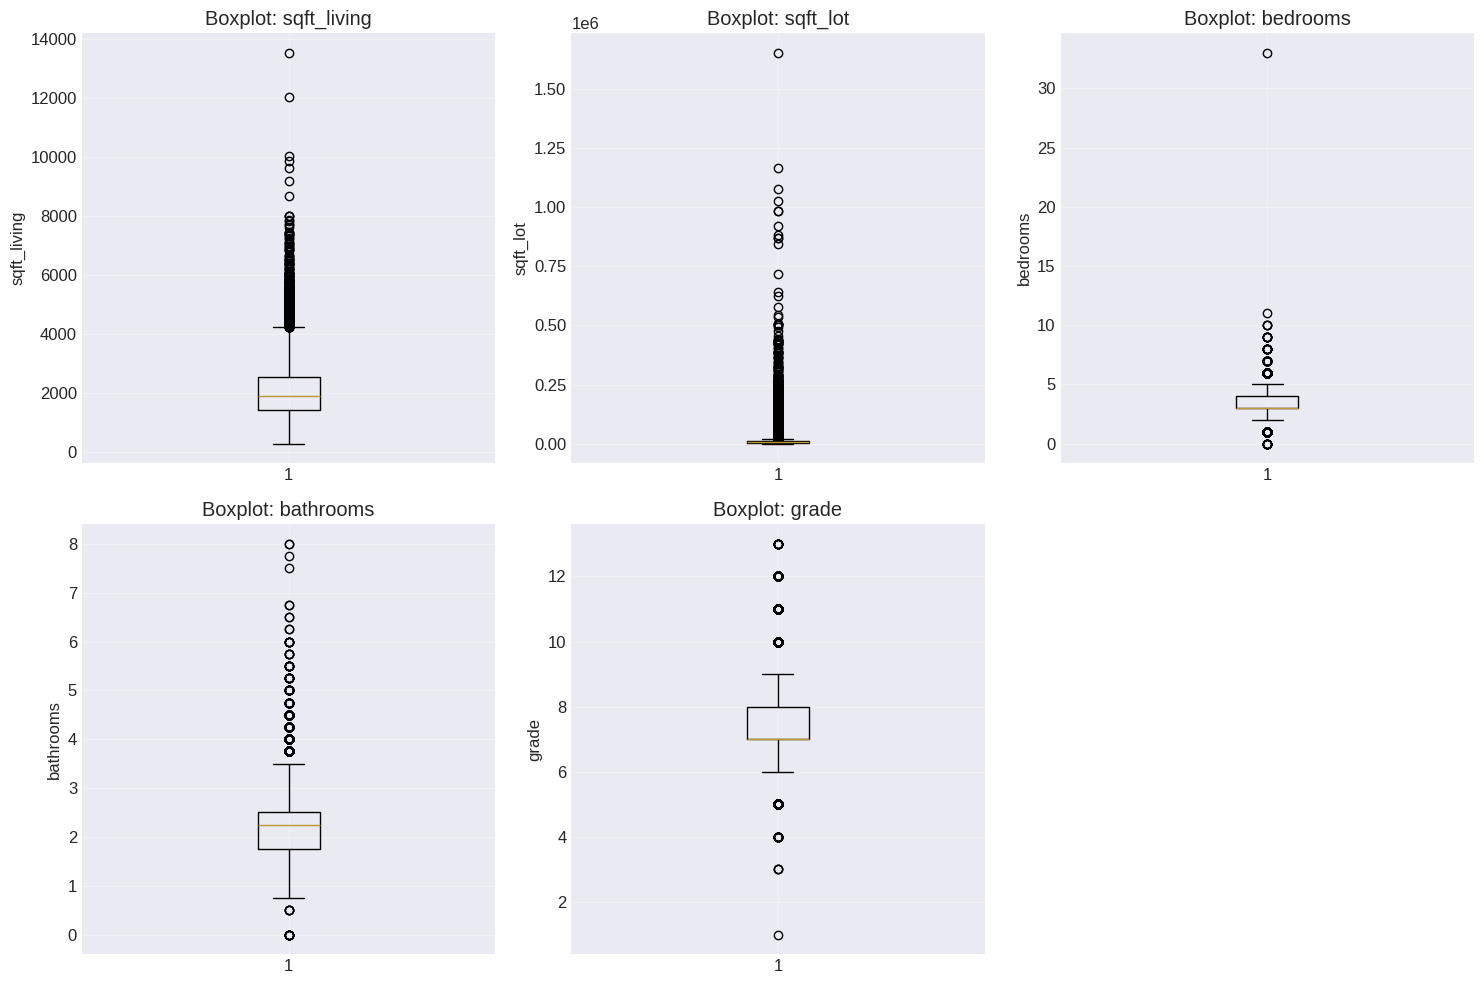

In [4]:
# Ячейка 2: АНАЛИЗ ДАТАСЕТА ДЛЯ РЕГРЕССИИ - ПРОГНОЗ ЦЕН НА ДОМА
# Загрузка датасета
df_reg = pd.read_csv('Regression.csv')
print(f"Датасет загружен: {df_reg.shape[0]} строк, {df_reg.shape[1]} столбцов")

# 2.1 Первичный обзор данных
print("\n--- 2.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_reg.head())
print("\nИнформация о типах данных:")
print(df_reg.info())

# 2.2 Статистическое описание
print("\n--- 2.2 Статистическое описание ---")
print(df_reg.describe())

# 2.3 Проверка пропущенных значений
print("\n--- 2.3 Проверка пропущенных значений ---")
missing_values_reg = df_reg.isnull().sum()
missing_percent_reg = (missing_values_reg / len(df_reg)) * 100

missing_df_reg = pd.DataFrame({
    'Количество пропусков': missing_values_reg,
    'Процент пропусков': missing_percent_reg
}).sort_values('Количество пропусков', ascending=False)

print(missing_df_reg[missing_df_reg['Количество пропусков'] > 0])
if missing_df_reg[missing_df_reg['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 2.4 Анализ целевой переменной (price)
print("\n--- 2.4 Анализ целевой переменной (price) ---")
price_stats = {
    'Медиана': df_reg['price'].median(),
    'Среднее значение': df_reg['price'].mean(),
    'Стандартное отклонение': df_reg['price'].std(),
    'Минимальная цена': df_reg['price'].min(),
    'Максимальная цена': df_reg['price'].max(),
    'Коэффициент вариации': (df_reg['price'].std() / df_reg['price'].mean() * 100)
}

for key, value in price_stats.items():
    if key != 'Коэффициент вариации':
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Визуализация распределения цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_reg['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(np.log1p(df_reg['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение цен (логарифмированное)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_reg['price'])
plt.title('Boxplot цен на дома')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.5 Анализ стандартных отклонений
print("\n--- 2.5 Анализ стандартных отклонений ---")
numeric_cols_reg = df_reg.select_dtypes(include=[np.number]).columns
std_dev_reg = df_reg[numeric_cols_reg].std()

std_df_reg = pd.DataFrame({
    'Стандартное отклонение': std_dev_reg,
    'Среднее значение': df_reg[numeric_cols_reg].mean(),
    'Коэффициент вариации': (std_dev_reg / df_reg[numeric_cols_reg].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df_reg.head(10))

# 2.6 Корреляция с целевой переменной (price)
print("\n--- 2.6 Корреляция с целевой переменной (price) ---")

# Исключаем неинформативные признаки (id, zipcode - это категориальные коды, а не числовые признаки)
exclude_features = ['id', 'zipcode']
numeric_features = [col for col in numeric_cols_reg if col not in exclude_features]

correlations_reg = df_reg[numeric_features].corrwith(df_reg['price']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с ценой:")
for i, (feature, corr_value) in enumerate(correlations_reg.head(10).items(), 1):
    actual_corr = df_reg[numeric_features].corrwith(df_reg['price'])[feature]
    print(f"{i:2}. {feature:20} {actual_corr:+.3f}")

# Визуализация матрицы корреляции
print("\n--- Матрица корреляции (без id и zipcode) ---")

# Создаем матрицу корреляции для осмысленных числовых признаков
corr_matrix = df_reg[numeric_features].corr()

# Определяем размер фигуры в зависимости от количества признаков
n_features = len(corr_matrix.columns)
figsize = max(14, n_features * 0.6), max(12, n_features * 0.6)

plt.figure(figsize=figsize)

# Создаем тепловую карту корреляций
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f',
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
           annot_kws={"size": 9})

plt.title('Матрица корреляции числовых признаков (без id и zipcode)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация о наиболее коррелирующих признаках
print("\n--- Анализ наиболее коррелирующих признаков ---")

# Находим пары признаков с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

if high_corr_pairs:
    print("Пары признаков с высокой корреляцией (|r| > 0.7):")
    print("-" * 60)
    for feat1, feat2, corr_value in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:15} и {feat2:15} => {corr_value:.3f}")
else:
    print("Нет пар признаков с высокой корреляцией (|r| > 0.7)")

# 2.7 Анализ выбросов в ключевых признаках
print("\n--- 2.7 Анализ выбросов в ключевых признаках ---")
key_features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

# Базовая информация о выбросах
for feature in key_features:
    if feature in df_reg.columns:
        Q1 = df_reg[feature].quantile(0.25)
        Q3 = df_reg[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_reg[(df_reg[feature] < lower_bound) | (df_reg[feature] > upper_bound)]
        n_outliers = len(outliers)
        
        print(f"{feature:15}: {n_outliers:4} выбросов ({n_outliers/len(df_reg)*100:.1f}%)")

# Визуализация
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    if feature in df_reg.columns:
        plt.subplot(2, 3, i)
        plt.boxplot(df_reg[feature].dropna())
        plt.title(f'Boxplot: {feature}')
        plt.ylabel(feature)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Создание безлайна и оценка качества

### Предобработка данных для задачи классификации

In [5]:
# Ячейка 3: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ЗАДАЧИ КЛАССИФИКАЦИИ
# 3.1 Создаем копию данных для обработки
df_class_processed = df_class.copy()
print("Создана копия данных для предобработки")

# 3.2 Удаляем неинформативные признаки
print("\n--- 1. Удаление неинформативных признаков ---")

columns_to_drop = [
    'EmployeeCount',      # Все значения = 1
    'EmployeeNumber',     # Уникальный идентификатор
    'Over18',             # Все значения = 'Y'
    'StandardHours'       # Все значения = 80
]

print(f"Удаляем признаки: {columns_to_drop}")
df_class_processed = df_class_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Осталось признаков: {df_class_processed.shape[1]}")

# 3.3 Преобразование целевой переменной
print("\n--- 2. Преобразование целевой переменной ---")
df_class_processed['Attrition'] = df_class_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("Целевая переменная Attrition преобразована: Yes -> 1, No -> 0")

# 3.4 Обработка категориальных признаков
print("\n--- 3. Обработка категориальных признаков ---")

categorical_cols = df_class_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для обработки ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = df_class_processed[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# One-Hot Encoding
print("\nПрименяем One-Hot Encoding для категориальных признаков...")
df_class_encoded = pd.get_dummies(df_class_processed, columns=categorical_cols, drop_first=True)
print(f"После кодирования: {df_class_encoded.shape[1]} признаков")

# 3.5 Разделение на признаки и целевую переменную
print("\n--- 4. Разделение данных ---")
X_class = df_class_encoded.drop('Attrition', axis=1)
y_class = df_class_encoded['Attrition']

print(f"Признаки (X): {X_class.shape}")
print(f"Целевая переменная (y): {y_class.shape}")

# 3.6 Стандартизация признаков
print("\n--- 5. Стандартизация признаков ---")
scaler_class = StandardScaler()
X_class_scaled = scaler_class.fit_transform(X_class)

print(f"Признаки после стандартизации: {X_class_scaled.shape}")
print(f"Стандартное отклонение первого признака: {X_class_scaled[:, 0].std():.6f}")

# 3.7 Разделение на обучающую и тестовую выборки
print("\n--- 6. Разделение на train/test ---")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Обучающая выборка: {X_train_class.shape}")
print(f"Тестовая выборка: {X_test_class.shape}")
print(f"Распределение классов в обучающей выборке: {np.bincount(y_train_class)}")
print(f"Распределение классов в тестовой выборке: {np.bincount(y_test_class)}")

Создана копия данных для предобработки

--- 1. Удаление неинформативных признаков ---
Удаляем признаки: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
Осталось признаков: 32

--- 2. Преобразование целевой переменной ---
Целевая переменная Attrition преобразована: Yes -> 1, No -> 0

--- 3. Обработка категориальных признаков ---
Категориальные признаки для обработки (7):
  BusinessTravel: 3 уникальных значений
  Department: 3 уникальных значений
  EducationField: 6 уникальных значений
  Gender: 2 уникальных значений
  JobRole: 9 уникальных значений
  MaritalStatus: 3 уникальных значений
  OverTime: 2 уникальных значений

Применяем One-Hot Encoding для категориальных признаков...
После кодирования: 46 признаков

--- 4. Разделение данных ---
Признаки (X): (1470, 45)
Целевая переменная (y): (1470,)

--- 5. Стандартизация признаков ---
Признаки после стандартизации: (1470, 45)
Стандартное отклонение первого признака: 1.000000

--- 6. Разделение на train/test ---
Обучающая выб

### Предобработка данных для задачи регрессии

In [6]:
# Ячейка 4: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ЗАДАЧИ РЕГРЕССИИ
# 4.1 Создаем копию данных для обработки
df_reg_processed = df_reg.copy()
print("Создана копия данных для предобработки")

# 4.2 Удаляем неинформативные признаки
print("\n--- 1. Удаление неинформативных признаков ---")

columns_to_drop_reg = ['id', 'zipcode']
print(f"Удаляем признаки: {columns_to_drop_reg}")
df_reg_processed = df_reg_processed.drop(columns=columns_to_drop_reg, errors='ignore')
print(f"Осталось признаков: {df_reg_processed.shape[1]}")

# 4.3 Обработка признака date
print("\n--- 2. Обработка временных признаков ---")

if 'date' in df_reg_processed.columns:
    df_reg_processed['date'] = pd.to_datetime(df_reg_processed['date'])
    df_reg_processed['sale_year'] = df_reg_processed['date'].dt.year
    df_reg_processed['sale_month'] = df_reg_processed['date'].dt.month
    df_reg_processed['sale_season'] = df_reg_processed['sale_month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    df_reg_processed = df_reg_processed.drop('date', axis=1)
    print(f"Извлечены признаки из даты: sale_year, sale_month, sale_season")

# 4.4 Обработка выбросов
print("\n--- 3. Обработка выбросов ---")

# Спальни: <1 или >5 → медиана
bedrooms_median = df_reg_processed['bedrooms'].median()
mask_bedrooms = (df_reg_processed['bedrooms'] < 1) | (df_reg_processed['bedrooms'] > 5)
if mask_bedrooms.any():
    n_bed = mask_bedrooms.sum()
    df_reg_processed.loc[mask_bedrooms, 'bedrooms'] = bedrooms_median
    print(f"Спальни: {n_bed} выбросов заменены на медиану ({bedrooms_median})")

# Ванные: <1 или >3 → медиана
bathrooms_median = df_reg_processed['bathrooms'].median()
mask_bathrooms = (df_reg_processed['bathrooms'] < 1) | (df_reg_processed['bathrooms'] > 3)
if mask_bathrooms.any():
    n_bath = mask_bathrooms.sum()
    df_reg_processed.loc[mask_bathrooms, 'bathrooms'] = bathrooms_median
    print(f"Ванные: {n_bath} выбросов заменены на медиану ({bathrooms_median:.1f})")

# Winsorization для sqft_lot и sqft_lot15
def winsorize_column(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

columns_to_winsorize = ['sqft_lot', 'sqft_lot15']
for col in columns_to_winsorize:
    if col in df_reg_processed.columns:
        old_min = df_reg_processed[col].min()
        old_max = df_reg_processed[col].max()
        df_reg_processed = winsorize_column(df_reg_processed, col)
        new_min = df_reg_processed[col].min()
        new_max = df_reg_processed[col].max()
        print(f"{col}: [{old_min:.0f}, {old_max:.0f}] -> [{new_min:.0f}, {new_max:.0f}]")

# 4.5 Логарифмирование
print("\n--- 4. Логарифмирование признаков ---")

df_reg_processed['price_log'] = np.log1p(df_reg_processed['price'])
print(f"Целевая переменная: price -> price_log")

for col in ['sqft_lot', 'sqft_lot15']:
    if col in df_reg_processed.columns:
        df_reg_processed[f'{col}_log'] = np.log1p(df_reg_processed[col])
        print(f"Создан логарифмированный признак: {col}_log")

# 4.6 Разделение на признаки и целевую переменную
print("\n--- 5. Разделение данных ---")

numeric_features_reg = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_features_reg = [col for col in numeric_features_reg if col not in ['price', 'price_log']]

X_reg = df_reg_processed[numeric_features_reg]
y_reg = df_reg_processed['price_log']

print(f"Признаки (X): {X_reg.shape}")
print(f"Целевая переменная (y): {y_reg.shape}")

# 4.7 Стандартизация признаков
print("\n--- 6. Стандартизация признаков ---")

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

print(f"Признаки после стандартизации: {X_reg_scaled.shape}")
print(f"Стандартное отклонение первого признака: {X_reg_scaled[:, 0].std():.6f}")

# 4.8 Разделение на обучающую и тестовую выборки
print("\n--- 7. Разделение на train/test ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg.shape}")
print(f"Тестовая выборка: {X_test_reg.shape}")

Создана копия данных для предобработки

--- 1. Удаление неинформативных признаков ---
Удаляем признаки: ['id', 'zipcode']
Осталось признаков: 19

--- 2. Обработка временных признаков ---
Извлечены признаки из даты: sale_year, sale_month, sale_season

--- 3. Обработка выбросов ---
Спальни: 347 выбросов заменены на медиану (3.0)
Ванные: 1963 выбросов заменены на медиану (2.2)
sqft_lot: [520, 1651359] -> [1013, 213008]
sqft_lot15: [651, 871200] -> [1191, 157687]

--- 4. Логарифмирование признаков ---
Целевая переменная: price -> price_log
Создан логарифмированный признак: sqft_lot_log
Создан логарифмированный признак: sqft_lot15_log

--- 5. Разделение данных ---
Признаки (X): (21613, 22)
Целевая переменная (y): (21613,)

--- 6. Стандартизация признаков ---
Признаки после стандартизации: (21613, 22)
Стандартное отклонение первого признака: 1.000000

--- 7. Разделение на train/test ---
Обучающая выборка: (17290, 22)
Тестовая выборка: (4323, 22)


### Построение безлайна для классификации


--- 1. Обучение базовой модели KNN ---
Обучаем модель KNN (k=5)...
Модель обучена успешно!

--- 2. Предсказания на тестовой выборке ---
Получено 294 предсказаний
Распределение предсказанных классов: [276  18]

--- 3. Оценка качества модели (метрики) ---
Основные метрики качества:
  • F1-score:       0.5538
  • Precision:      1.0000
  • Recall:         0.3830

--- 4. Матрица ошибок ---
Матрица ошибок:
                  Предсказано
                Нет     Да
Фактически Нет  [247]  [  0]
            Да   [ 29]  [ 18]

Дополнительные метрики:
  • Accuracy:       0.9014
  • False Positive: 0 (0.0% от класса 'Нет')
  • False Negative: 29 (61.7% от класса 'Да')

--- 5. Визуализация матрицы ошибок ---


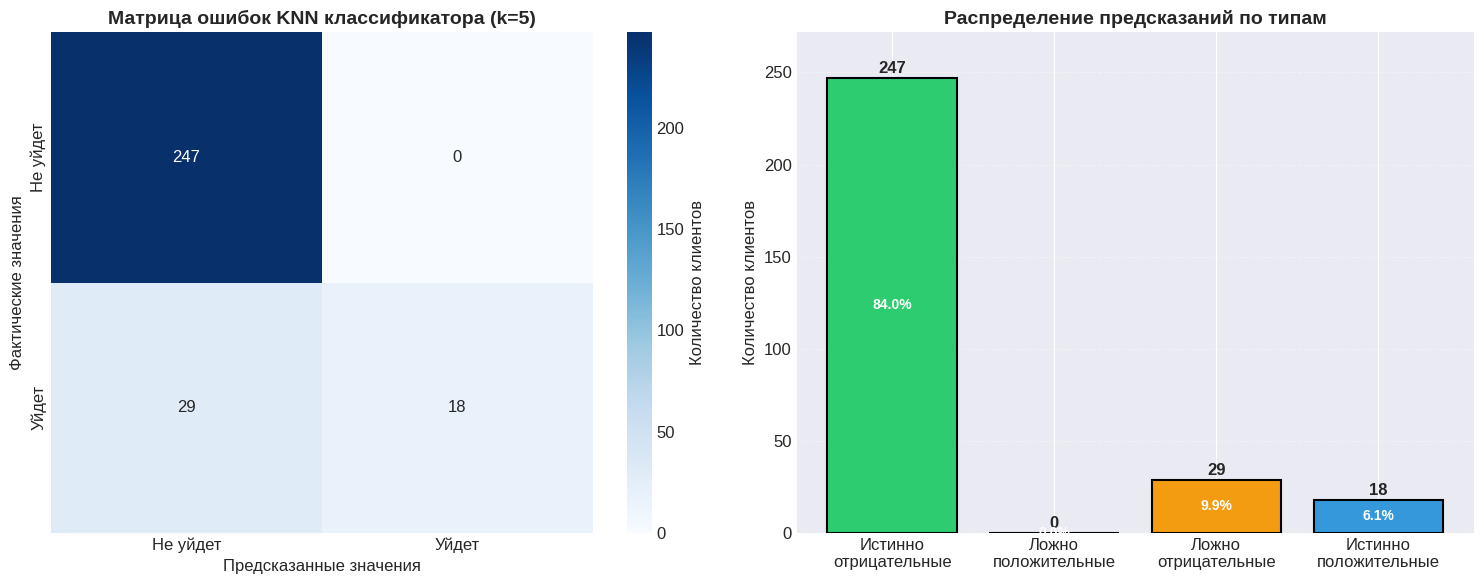


1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 265 (90.1%)
   Ошибок предсказаний: 29 (9.9%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 247 клиентов
   • Точность для класса: 100.0%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 18 клиентов
   • Точность для класса: 38.3%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 29
   Из них:
   • Ложные срабатывания (False Positive): 0
     - Клиентов, которые не уйдут, но мы предскажем уход: 0
     - Это 0.0% от всех предсказаний
   • Пропущенные случаи (False Negative): 29
     - Клиентов, которые уйдут, но мы не предскажем: 29
     - Это 9.9% от всех предсказаний

--- 6. Сравнение фактического и предсказанного распределения ---


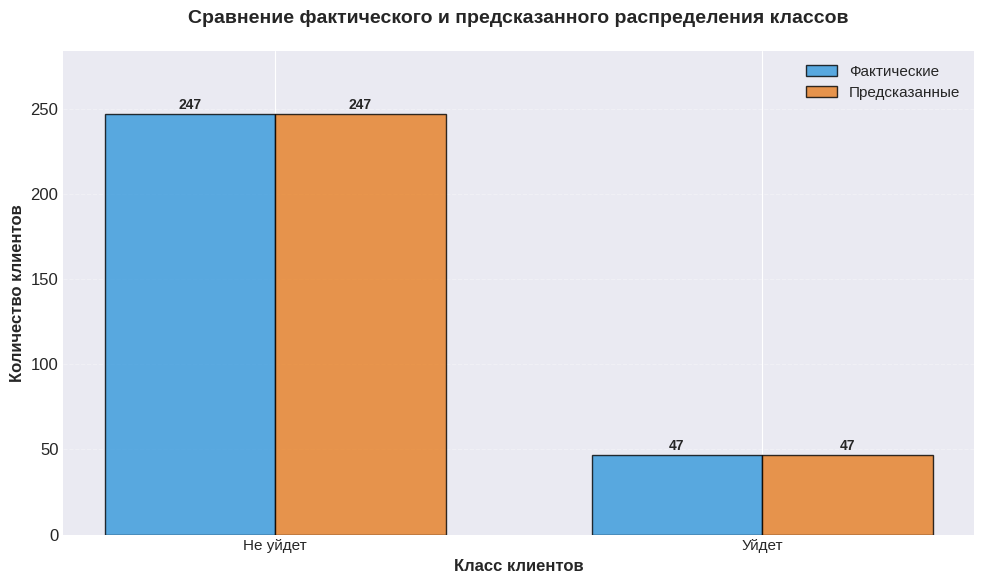


--- 7. Полный отчет о классификации ---
              precision    recall  f1-score   support

    Не уйдет       0.89      1.00      0.94       247
       Уйдет       1.00      0.38      0.55        47

    accuracy                           0.90       294
   macro avg       0.95      0.69      0.75       294
weighted avg       0.91      0.90      0.88       294



In [7]:
# Ячейка 5: ПОСТРОЕНИЕ БЕЗЛАЙНА ДЛЯ КЛАССИФИКАЦИИ 
# 5.1 Обучение базовой модели KNN
print("\n--- 1. Обучение базовой модели KNN ---")

# Создаем модель KNN с параметрами по умолчанию (k=5)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Обучаем модель на обучающей выборке
print("Обучаем модель KNN (k=5)...")
knn_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# 5.2 Предсказания на тестовой выборке
print("\n--- 2. Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_class = knn_classifier.predict(X_test_class)
y_pred_proba_class = knn_classifier.predict_proba(X_test_class)[:, 1]  # Вероятности класса 1

print(f"Получено {len(y_pred_class)} предсказаний")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_class.astype(int))}")

# 5.3 Оценка качества модели
print("\n--- 3. Оценка качества модели (метрики) ---")

# Основные метрики
f1 = f1_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)

print("Основные метрики качества:")
print(f"  • F1-score:       {f1:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")

# 5.4 Матрица ошибок (Confusion Matrix)
print("\n--- 4. Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn:3d}]  [{fp:3d}]")
print(f"            Да   [{fn:3d}]  [{tp:3d}]")
print()

# Дополнительные метрики из матрицы ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Дополнительные метрики:")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • False Positive: {fp} ({fp/(fp+tn)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn} ({fn/(fn+tp)*100:.1f}% от класса 'Да')")

# 5.5 ВИЗУАЛИЗАЦИЯ МАТРИЦЫ ОШИБОК КАК ГРАФИКА
print("\n--- 5. Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок KNN классификатора (k=5)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn, fp, fn, tp]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний по типам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 5.6 АНАЛИЗ ПРАВИЛЬНОСТИ ПРЕДСКАЗАНИЙ

# Общая статистика по предсказаниям
total_predictions = len(y_pred_class)
correct_predictions = tp + tn
incorrect_predictions = fp + fn

print(f"\n1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn
total_not_churn_actual = tn + fp
accuracy_not_churn = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp
total_churn_actual = tp + fn
accuracy_churn = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# Статистика ошибок
print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp}")
print(f"     - Это {fp/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn}")
print(f"     - Это {fn/total_predictions*100:.1f}% от всех предсказаний")

# 5.7 СРАВНЕНИЕ ФАКТИЧЕСКОГО И ПРЕДСКАЗАННОГО РАСПРЕДЕЛЕНИЯ
print("\n--- 6. Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
actual_counts = [total_not_churn_actual, total_churn_actual]
# Предсказанные значения
predicted_counts = [(tn + fp), (tp + fn)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title('Сравнение фактического и предсказанного распределения классов', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы с улучшенным форматированием
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 5.8 Полный отчет о классификации
print("\n--- 7. Полный отчет о классификации ---")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['Не уйдет', 'Уйдет']))


### Построение безлайна для регрессии


--- 1. Обучение базовой модели KNN регрессии ---
Обучаем модель KNN регрессии (k=5)...
Модель обучена успешно!

--- 2. Предсказания на тестовой выборке ---
Получено 4323 предсказаний цен
Примеры предсказанных цен (первые 5): $[ 478508  615603 1073491 1507210  752023]
Примеры фактических цен (первые 5):   $[ 364999  864999 1037999 1490000  711000]

--- 3. Оценка качества модели (метрики) ---
Метрики в логарифмированной шкале (более устойчивые):
  • RMSE (log scale): 0.2344
  • MAE (log scale):  0.1732

Метрики в оригинальной шкале (доллары):
  • RMSE:            $190,682
  • MAE:             $101,039
  • MAPE:            17.58%
  • R²:              0.7595

--- 4. Визуализация результатов регрессии ---


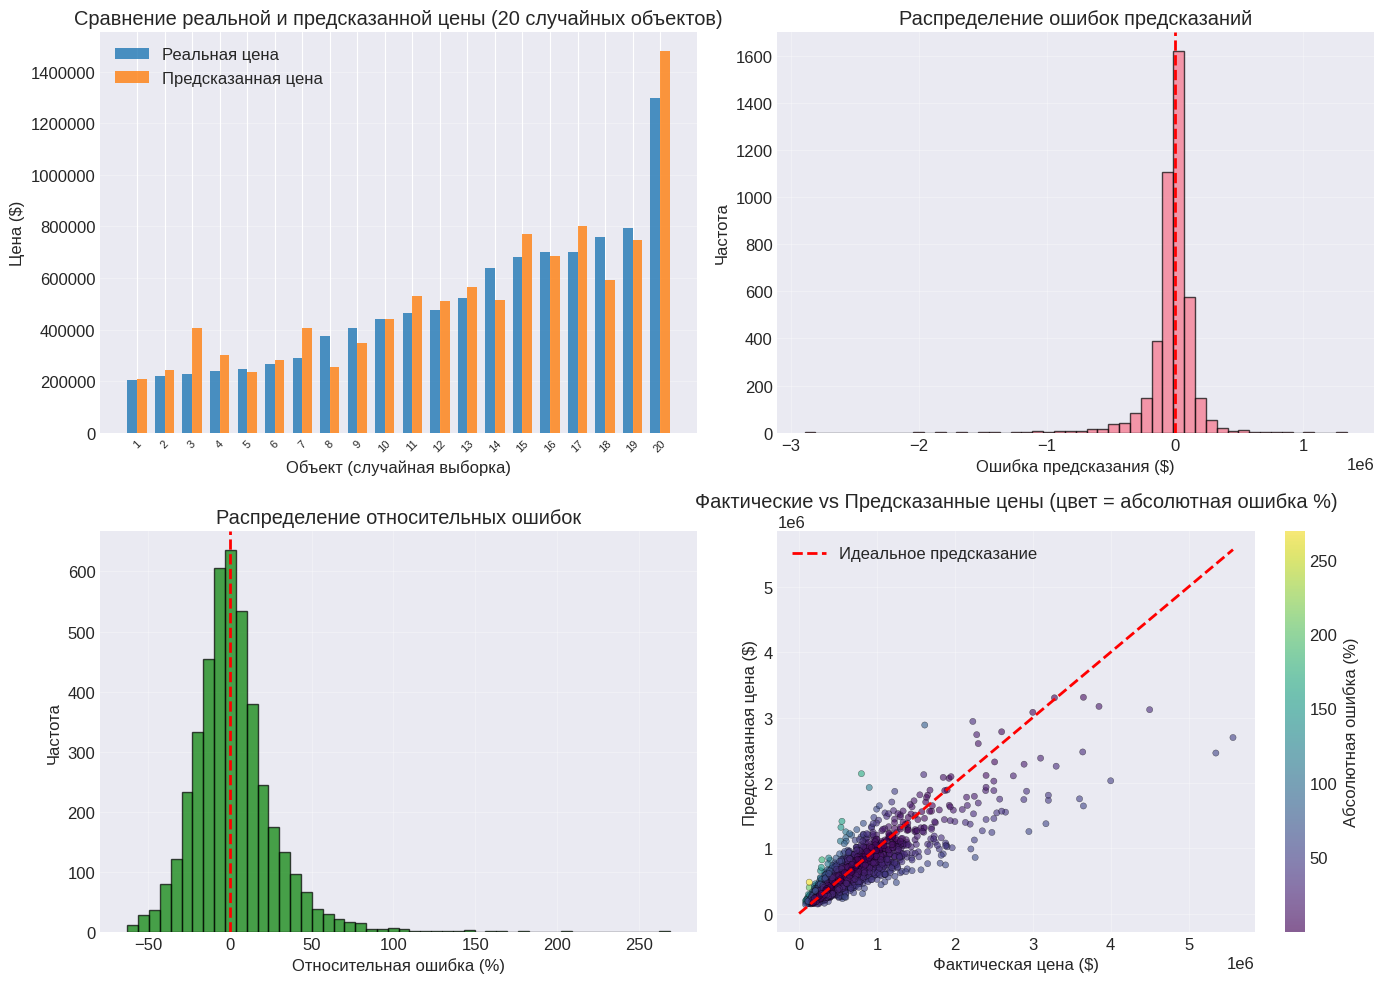


--- 5. Статистика ошибок предсказаний ---
Процентили абсолютных ошибок (в долларах):
  • 25%: $23,573
  • 50% (медиана): $56,078
  • 75%: $115,958
  • 90%: $220,212
  • 95%: $333,743

Процент предсказаний с заданной точностью:
  • Ошибка ≤ 10%: 41.4% предсказаний
  • Ошибка ≤ 20%: 67.5% предсказаний
  • Ошибка ≤ 30%: 83.2% предсказаний

--- 6. Сравнение реальных и предсказанных цен ---
Средняя цена: реальная = $549,367, предсказанная = $526,048
Медианная цена: реальная = $455,000, предсказанная = $457,687
Средняя ошибка: $-23,319
Средняя абсолютная ошибка: $101,039 (17.6%)


In [8]:
# Ячейка 6: ПОСТРОЕНИЕ БЕЗЛАЙНА ДЛЯ РЕГРЕССИИ
# 6.1 Обучение базовой модели KNN для регрессии
print("\n--- 1. Обучение базовой модели KNN регрессии ---")

# Создаем модель KNN регрессии с параметрами по умолчанию (k=5)
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

# Обучаем модель на обучающей выборке
print("Обучаем модель KNN регрессии (k=5)...")
knn_regressor.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# 6.2 Предсказания на тестовой выборке
print("\n--- 2. Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные цены)
y_pred_reg_log = knn_regressor.predict(X_test_reg)

# Преобразуем обратно из логарифма в обычные цены
y_pred_reg = np.expm1(y_pred_reg_log)
y_test_reg_original = np.expm1(y_test_reg)

print(f"Получено {len(y_pred_reg)} предсказаний цен")

print(f"Примеры предсказанных цен (первые 5): ${y_pred_reg[:5].astype(int)}")
print(f"Примеры фактических цен (первые 5):   ${y_test_reg_original.values[:5].astype(int)}") 

# 6.3 Оценка качества модели (основные метрики)
print("\n--- 3. Оценка качества модели (метрики) ---")

# Основные метрики в логарифмированной шкале (более устойчивые)
rmse_log = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log))
mae_log = mean_absolute_error(y_test_reg, y_pred_reg_log)

# Метрики в оригинальной шкале (доллары)
rmse = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae = mean_absolute_error(y_test_reg_original, y_pred_reg)
mape = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2 = r2_score(y_test_reg_original, y_pred_reg)

print("Метрики в логарифмированной шкале (более устойчивые):")
print(f"  • RMSE (log scale): {rmse_log:.4f}")
print(f"  • MAE (log scale):  {mae_log:.4f}")

print("\nМетрики в оригинальной шкале (доллары):")
print(f"  • RMSE:            ${rmse:,.0f}")
print(f"  • MAE:             ${mae:,.0f}")
print(f"  • MAPE:            {mape*100:.2f}%")
print(f"  • R²:              {r2:.4f}")

# 6.4 ВИЗУАЛИЗАЦИЯ: РЕАЛЬНЫЕ vs ПРЕДСКАЗАННЫЕ ЦЕНЫ
print("\n--- 4. Визуализация результатов регрессии ---")

# Создаем DataFrame для удобства анализа
results_df = pd.DataFrame({
    'Фактическая_цена': y_test_reg_original.values,
    'Предсказанная_цена': y_pred_reg,
    'Относительная_ошибка_%': ((y_pred_reg - y_test_reg_original.values) / y_test_reg_original.values) * 100
})

# Рассчитываем ошибки для графиков
errors = y_pred_reg - y_test_reg_original
relative_errors = (errors / y_test_reg_original) * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Сравнение реальной и предсказанной цены для случайных 20 объектов
np.random.seed(42)  # Для воспроизводимости
sample_indices = np.random.choice(len(results_df), min(20, len(results_df)), replace=False)
sample_df = results_df.iloc[sample_indices].sort_values('Фактическая_цена')

x_pos = np.arange(len(sample_df))
width = 0.35

bars_actual = axes[0, 0].bar(x_pos - width/2, sample_df['Фактическая_цена'], 
                            width, label='Реальная цена', color='#1f77b4', alpha=0.8)
bars_pred = axes[0, 0].bar(x_pos + width/2, sample_df['Предсказанная_цена'], 
                          width, label='Предсказанная цена', color='#ff7f0e', alpha=0.8)

axes[0, 0].set_xlabel('Объект (случайная выборка)')
axes[0, 0].set_ylabel('Цена ($)')
axes[0, 0].set_title('Сравнение реальной и предсказанной цены (20 случайных объектов)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'{i+1}' for i in range(len(sample_df))], rotation=45, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# График 2: Ошибки предсказаний
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Ошибка предсказания ($)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок предсказаний')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Относительные ошибки
axes[1, 0].hist(relative_errors, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Относительная ошибка (%)')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение относительных ошибок')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Фактические vs Предсказанные цены (scatter с тепловой картой)
scatter = axes[1, 1].scatter(results_df['Фактическая_цена'], results_df['Предсказанная_цена'],
                            c=np.abs(results_df['Относительная_ошибка_%']),
                            cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

# Линия идеального предсказания
max_price = max(results_df['Фактическая_цена'].max(), results_df['Предсказанная_цена'].max())
axes[1, 1].plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Идеальное предсказание')

axes[1, 1].set_xlabel('Фактическая цена ($)')
axes[1, 1].set_ylabel('Предсказанная цена ($)')
axes[1, 1].set_title('Фактические vs Предсказанные цены (цвет = абсолютная ошибка %)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Абсолютная ошибка (%)')

plt.tight_layout()
plt.show()

# 6.5 Статистика ошибок
print("\n--- 5. Статистика ошибок предсказаний ---")

# Процентили ошибок
error_percentiles = np.percentile(np.abs(errors), [25, 50, 75, 90, 95])
print("Процентили абсолютных ошибок (в долларах):")
print(f"  • 25%: ${error_percentiles[0]:,.0f}")
print(f"  • 50% (медиана): ${error_percentiles[1]:,.0f}")
print(f"  • 75%: ${error_percentiles[2]:,.0f}")
print(f"  • 90%: ${error_percentiles[3]:,.0f}")
print(f"  • 95%: ${error_percentiles[4]:,.0f}")

# Процент предсказаний с разной точностью
within_10_percent = np.sum(np.abs(relative_errors) <= 10) / len(relative_errors) * 100
within_20_percent = np.sum(np.abs(relative_errors) <= 20) / len(relative_errors) * 100
within_30_percent = np.sum(np.abs(relative_errors) <= 30) / len(relative_errors) * 100

print("\nПроцент предсказаний с заданной точностью:")
print(f"  • Ошибка ≤ 10%: {within_10_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 20%: {within_20_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 30%: {within_30_percent:.1f}% предсказаний")

# 6.6 Сравнение реальных и предсказанных цен
print("\n--- 6. Сравнение реальных и предсказанных цен ---")

mean_actual = y_test_reg_original.mean()
mean_pred = y_pred_reg.mean()
median_actual = np.median(y_test_reg_original)
median_pred = np.median(y_pred_reg)

print(f"Средняя цена: реальная = ${mean_actual:,.0f}, предсказанная = ${mean_pred:,.0f}")
print(f"Медианная цена: реальная = ${median_actual:,.0f}, предсказанная = ${median_pred:,.0f}")
print(f"Средняя ошибка: ${np.mean(errors):,.0f}")
print(f"Средняя абсолютная ошибка: ${mae:,.0f} ({mape*100:.1f}%)")

## 3. Улучшение Безлайна

### Гипотезы для улучшения

**Для классификации**:

**Основная проблема бейзлайна**: Низкий Recall (0.383) - модель пропускает 62% реальных увольнений при идеальном Precision (1.0).

Гипотезы для улучшения:

1. Уменьшение k - сделает модель более чувствительной к локальным закономерностям

2. Использование весов (weights='distance') - ближайшие соседи будут иметь больший вес

3. Изменение метрики расстояния - Manhattan может лучше работать после One-Hot кодирования

4. Настройка порога классификации - снижение порога с 0.5 увеличит Recall

5. Оптимизация через кросс-валидацию - системный поиск лучших гиперпараметров

**Для регрессии**:

**Основные проблемы бейзлайна**: Высокий RMSE ($149K) и ошибки для дорогих домов.

Гипотезы для улучшения:

1. Оптимальное k в диапазоне 3-15 - поиск баланса между локальностью и стабильностью

2. Взвешенные расстояния - улучшение точности за счет учета близости соседей

3. Использование Manhattan distance - более устойчива к разным масштабам признаков

4. GridSearch с кросс-валидацией - поиск оптимальной комбинации параметров


--- 7.1 Проверка гипотез и подбор гиперпараметров для классификации ---
Запускаем GridSearchCV для классификации...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Результаты поиска лучших параметров:
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Лучший F1-score на кросс-валидации: 0.6954

--- 7.2 Формирование улучшенной модели классификации ---
Улучшенная модель классификации создана:
  • n_neighbors: 3
  • weights: 'uniform'
  • metric: 'euclidean'

--- 7.3 Обучение улучшенной модели классификации ---
Улучшенная модель классификации обучена на обучающих данных.

--- 7.4 Оценка качества улучшенной модели (порог 0.5) ---
Основные метрики улучшенной модели (порог 0.5):
  • F1-score:       0.5970
  • Precision:      1.0000
  • Recall:         0.4255
  • Accuracy:       0.9082

Матрица ошибок улучшенной модели (порог 0.5):
                  Предсказано
                Нет     Да
Фактически Нет  [247]  [  0]
            Да   [ 27]  [ 20]


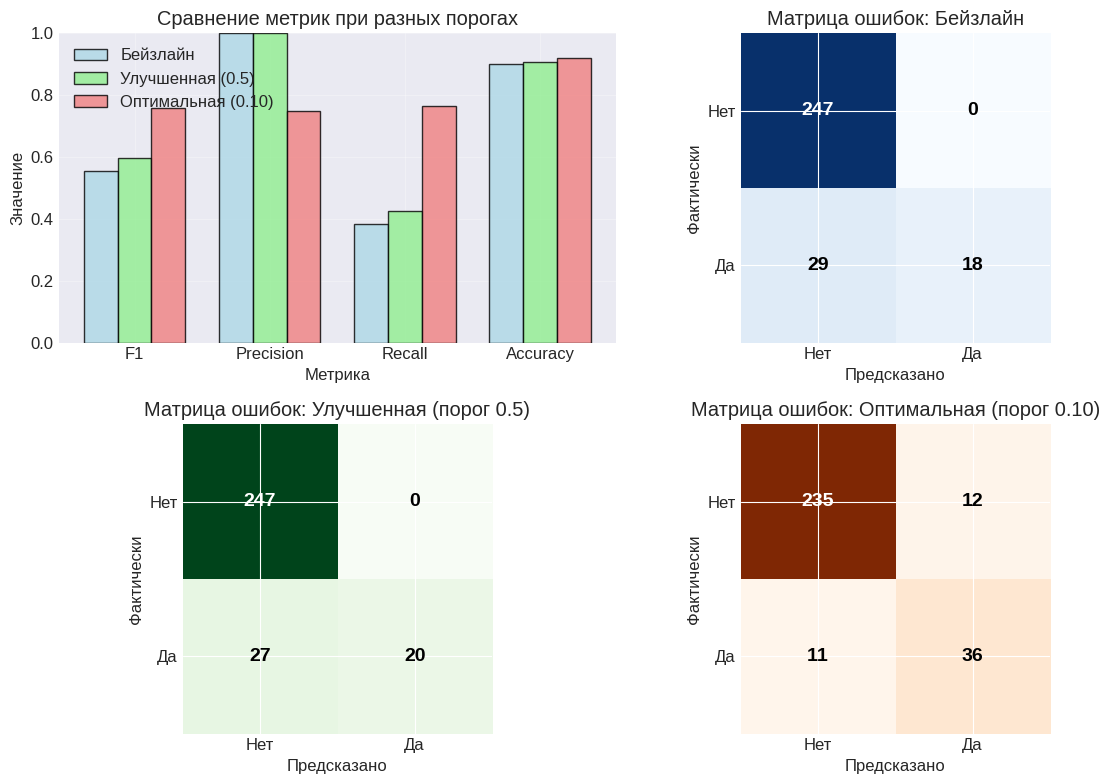


--- 7.8 Визуализация влияния порога на метрики ---


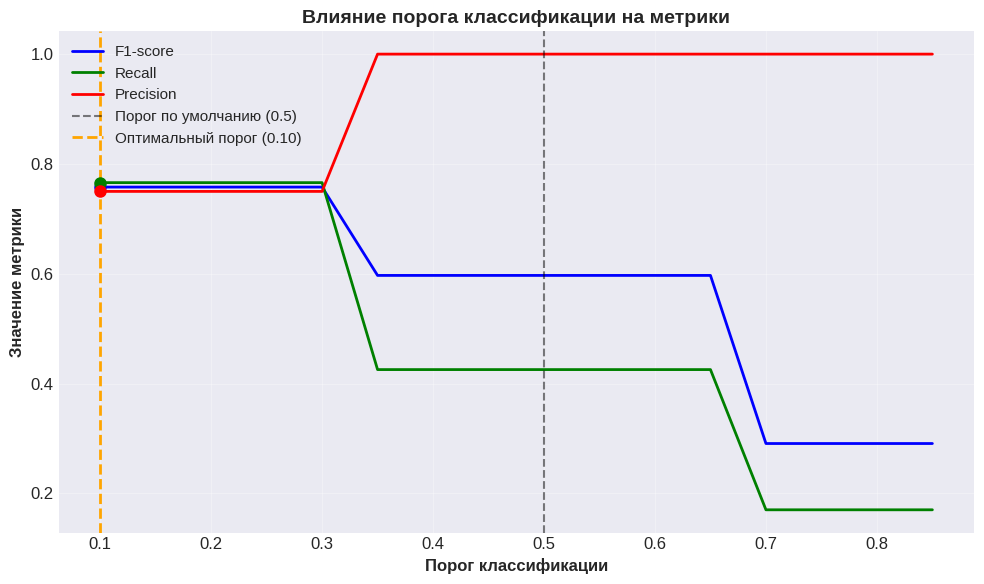


--- 7.9 Полный отчет о классификации ---
Отчет для улучшенной модели с оптимальным порогом:
              precision    recall  f1-score   support

    Не уйдет       0.96      0.95      0.95       247
       Уйдет       0.75      0.77      0.76        47

    accuracy                           0.92       294
   macro avg       0.85      0.86      0.86       294
weighted avg       0.92      0.92      0.92       294



In [9]:
# Ячейка 7: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ КЛАССИФИКАЦИИ
# 7.1 Проверка гипотез и подбор киперпараметров
print("\n--- 7.1 Проверка гипотез и подбор гиперпараметров для классификации ---")

# Параметры для GridSearch
param_grid_class = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

# Используем F1-score для оценки
grid_search_class = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_class,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Запускаем GridSearchCV для классификации...")
grid_search_class.fit(X_train_class, y_train_class)

print("\nРезультаты поиска лучших параметров:")
print(f"Лучшие параметры: {grid_search_class.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search_class.best_score_:.4f}")

# 7.2 Формирование улучшенной модели
print("\n--- 7.2 Формирование улучшенной модели классификации ---")

# Создаем улучшенную модель с лучшими параметрами
best_knn_classifier = grid_search_class.best_estimator_

print(f"Улучшенная модель классификации создана:")
print(f"  • n_neighbors: {best_knn_classifier.get_params()['n_neighbors']}")
print(f"  • weights: '{best_knn_classifier.get_params()['weights']}'")
print(f"  • metric: '{best_knn_classifier.get_params()['metric']}'")

# 7.3 Обучение улучшенной модели
print("\n--- 7.3 Обучение улучшенной модели классификации ---")

best_knn_classifier.fit(X_train_class, y_train_class)
print("Улучшенная модель классификации обучена на обучающих данных.")

# 7.4 Оценка качества
print("\n--- 7.4 Оценка качества улучшенной модели (порог 0.5) ---")

# Предсказания с порогом 0.5 (по умолчанию)
y_pred_class_improved = best_knn_classifier.predict(X_test_class)
y_pred_proba_class_improved = best_knn_classifier.predict_proba(X_test_class)[:, 1]

# Метрики с порогом 0.5
f1_improved_05 = f1_score(y_test_class, y_pred_class_improved)
precision_improved_05 = precision_score(y_test_class, y_pred_class_improved)
recall_improved_05 = recall_score(y_test_class, y_pred_class_improved)
accuracy_improved_05 = (y_pred_class_improved == y_test_class).mean()

print("Основные метрики улучшенной модели (порог 0.5):")
print(f"  • F1-score:       {f1_improved_05:.4f}")
print(f"  • Precision:      {precision_improved_05:.4f}")
print(f"  • Recall:         {recall_improved_05:.4f}")
print(f"  • Accuracy:       {accuracy_improved_05:.4f}")

# Матрица ошибок с порогом 0.5
cm_improved_05 = confusion_matrix(y_test_class, y_pred_class_improved)
tn_05, fp_05, fn_05, tp_05 = cm_improved_05.ravel()

print("\nМатрица ошибок улучшенной модели (порог 0.5):")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_05:3d}]  [{fp_05:3d}]")
print(f"            Да   [{fn_05:3d}]  [{tp_05:3d}]")

# 7.5 Настройка порога
print("\n--- 7.5 Настройка порога классификации ---")

# Анализ разных порогов классификации
thresholds = np.arange(0.1, 0.9, 0.1)
print(f"{'Порог':<8} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Класс 1':<10}")
print("-" * 55)

best_f1 = 0
best_threshold = 0.5
best_predictions = None

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_class_improved >= threshold).astype(int)
    
    if sum(y_pred_threshold) > 0:
        precision_t = precision_score(y_test_class, y_pred_threshold)
        recall_t = recall_score(y_test_class, y_pred_threshold)
        f1_t = f1_score(y_test_class, y_pred_threshold)
        n_class1 = sum(y_pred_threshold)
        
        print(f"{threshold:<8.1f} {precision_t:<10.4f} {recall_t:<10.4f} {f1_t:<10.4f} {n_class1:<10}")
        
        if f1_t > best_f1:
            best_f1 = f1_t
            best_threshold = threshold
            best_predictions = y_pred_threshold
    else:
        print(f"{threshold:<8.1f} {'-':<10} {'-':<10} {'-':<10} {0:<10}")

print(f"\nОптимальный порог: {best_threshold:.2f} (F1={best_f1:.4f})")

# Предсказания с оптимальным порогом
y_pred_optimal = best_predictions if best_predictions is not None else y_pred_class_improved
f1_optimal = f1_score(y_test_class, y_pred_optimal)
precision_optimal = precision_score(y_test_class, y_pred_optimal)
recall_optimal = recall_score(y_test_class, y_pred_optimal)
accuracy_optimal = (y_pred_optimal == y_test_class).mean()
cm_optimal = confusion_matrix(y_test_class, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()

print(f"\nМетрики с оптимальным порогом {best_threshold:.2f}:")
print(f"  • F1-score:       {f1_optimal:.4f}")
print(f"  • Precision:      {precision_optimal:.4f}")
print(f"  • Recall:         {recall_optimal:.4f}")
print(f"  • Accuracy:       {accuracy_optimal:.4f}")

# 7.6 Сравнение
print("\n--- 7.6 Сравнение результатов с бейзлайном ---")

# Метрики бейзлайна (из ячейки 5)
f1_base = f1
precision_base = precision
recall_base = recall
accuracy_base = accuracy
cm_base = confusion_matrix(y_test_class, y_pred_class)

print("\n1. СРАВНЕНИЕ С ПОРОГОМ 0.5:")
print("-" * 70)
print(f"{'Метрика':<15} {'Бейзлайн':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

for metric_name, base_val, improved_val in [
    ("F1-score", f1_base, f1_improved_05),
    ("Precision", precision_base, precision_improved_05),
    ("Recall", recall_base, recall_improved_05),
    ("Accuracy", accuracy_base, accuracy_improved_05)
]:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print(f"\nМатрицы ошибок (порог 0.5):")
print(f"Бейзлайн:    TN={cm_base[0,0]}, FP={cm_base[0,1]}, FN={cm_base[1,0]}, TP={cm_base[1,1]}")
print(f"Улучшенная:  TN={tn_05}, FP={fp_05}, FN={fn_05}, TP={tp_05}")
print(f"Улучшения: TP +{tp_05 - cm_base[1,1]}, FN -{cm_base[1,0] - fn_05}")

print(f"\n\n2. СРАВНЕНИЕ С ОПТИМАЛЬНЫМ ПОРОГОМ {best_threshold:.2f}:")
print("-" * 70)
print(f"{'Метрика':<15} {'Бейзлайн':<12} {'Оптимальная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

for metric_name, base_val, optimal_val in [
    ("F1-score", f1_base, f1_optimal),
    ("Precision", precision_base, precision_optimal),
    ("Recall", recall_base, recall_optimal),
    ("Accuracy", accuracy_base, accuracy_optimal)
]:
    change = optimal_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<15} {base_val:<12.4f} {optimal_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print(f"\nМатрицы ошибок (порог {best_threshold:.2f}):")
print(f"Бейзлайн:    TN={cm_base[0,0]}, FP={cm_base[0,1]}, FN={cm_base[1,0]}, TP={cm_base[1,1]}")
print(f"Оптимальная: TN={tn_opt}, FP={fp_opt}, FN={fn_opt}, TP={tp_opt}")
print(f"Улучшения: TP +{tp_opt - cm_base[1,1]}, FN -{cm_base[1,0] - fn_opt}, FP +{fp_opt - cm_base[0,1]}")

print(f"\n\n3. ВЛИЯНИЕ НАСТРОЙКИ ПОРОГА:")
print("-" * 70)
print(f"Настройка порога с 0.5 до {best_threshold:.2f} дает:")
print(f"  • F1-score: +{(f1_optimal - f1_improved_05):.4f} (+{(f1_optimal - f1_improved_05)/f1_improved_05*100:.1f}%)")
print(f"  • Recall: +{(recall_optimal - recall_improved_05):.4f} (+{(recall_optimal - recall_improved_05)/recall_improved_05*100:.1f}%)")
print(f"  • Precision: {(precision_optimal - precision_improved_05):.4f} ({(precision_optimal - precision_improved_05)/precision_improved_05*100:.1f}%)")

# 7.7 Визуализация
print("\n--- 7.7 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Сравнение метрик (порог 0.5)
metrics = ['F1', 'Precision', 'Recall', 'Accuracy']
base_vals = [f1_base, precision_base, recall_base, accuracy_base]
improved_vals_05 = [f1_improved_05, precision_improved_05, recall_improved_05, accuracy_improved_05]
optimal_vals = [f1_optimal, precision_optimal, recall_optimal, accuracy_optimal]

x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, base_vals, width, label='Бейзлайн', alpha=0.8, color='lightblue', edgecolor='black')
axes[0, 0].bar(x, improved_vals_05, width, label='Улучшенная (0.5)', alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 0].bar(x + width, optimal_vals, width, label=f'Оптимальная ({best_threshold:.2f})', alpha=0.8, color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик при разных порогах')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Матрица ошибок - Бейзлайн
im1 = axes[0, 1].imshow(cm_base, cmap='Blues')
axes[0, 1].set_title('Матрица ошибок: Бейзлайн')
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j, i, cm_base[i, j], ha='center', va='center', 
                       color='white' if cm_base[i, j] > cm_base.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Нет', 'Да'])
axes[0, 1].set_yticklabels(['Нет', 'Да'])
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная (порог 0.5)
im2 = axes[1, 0].imshow(cm_improved_05, cmap='Greens')
axes[1, 0].set_title('Матрица ошибок: Улучшенная (порог 0.5)')
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, cm_improved_05[i, j], ha='center', va='center', 
                       color='white' if cm_improved_05[i, j] > cm_improved_05.max()/2 else 'black',
                       fontsize=14, fontweight='bold')

axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Нет', 'Да'])
axes[1, 0].set_yticklabels(['Нет', 'Да'])
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Матрица ошибок - Оптимальная (порог best_threshold)
im3 = axes[1, 1].imshow(cm_optimal, cmap='Oranges')
axes[1, 1].set_title(f'Матрица ошибок: Оптимальная (порог {best_threshold:.2f})')
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm_optimal[i, j], ha='center', va='center', 
                       color='white' if cm_optimal[i, j] > cm_optimal.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
 
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Нет', 'Да'])
axes[1, 1].set_yticklabels(['Нет', 'Да'])
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Фактически')

plt.tight_layout()
plt.show()

print("\n--- 7.8 Визуализация влияния порога на метрики ---")

fig, ax = plt.subplots(figsize=(10, 6))

thresholds_detailed = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

for threshold in thresholds_detailed:
    y_pred_threshold = (y_pred_proba_class_improved >= threshold).astype(int)
    if sum(y_pred_threshold) > 0:
        f1_scores.append(f1_score(y_test_class, y_pred_threshold))
        recall_scores.append(recall_score(y_test_class, y_pred_threshold))
        precision_scores.append(precision_score(y_test_class, y_pred_threshold))
    else:
        f1_scores.append(0)
        recall_scores.append(0)
        precision_scores.append(0)

ax.plot(thresholds_detailed, f1_scores, 'b-', label='F1-score', linewidth=2)
ax.plot(thresholds_detailed, recall_scores, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_detailed, precision_scores, 'r-', label='Precision', linewidth=2)
ax.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Порог по умолчанию (0.5)')
ax.axvline(x=best_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Оптимальный порог ({best_threshold:.2f})')

# Отметим точки для 0.1, 0.3, 0.5, 0.7
for thr in [0.1, 0.3, 0.5, 0.7]:
    if thr in thresholds_detailed:
        idx = list(thresholds_detailed).index(thr)
        ax.plot(thr, f1_scores[idx], 'bo', markersize=8)
        ax.plot(thr, recall_scores[idx], 'go', markersize=8)
        ax.plot(thr, precision_scores[idx], 'ro', markersize=8)

ax.set_xlabel('Порог классификации', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax.set_title('Влияние порога классификации на метрики', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7.8 Отчет
print("\n--- 7.9 Полный отчет о классификации ---")
print("Отчет для улучшенной модели с оптимальным порогом:")
print(classification_report(y_test_class, y_pred_optimal, 
                           target_names=['Не уйдет', 'Уйдет']))


--- 8.1 Проверка гипотез и подбор гиперпараметров для регрессии ---

1. БЕЙЗЛАЙН МОДЕЛЬ (k=5, uniform, euclidean)
   • RMSE на тесте:     $190,682
   • RMSE на CV (train): $180,223
   • MAE:               $101,039
   • MAPE:              17.58%
   • R²:                0.7595

2. ВЛИЯНИЕ ПАРАМЕТРА k
----------------------------------------
k= 3: RMSE (доллары) = $180,079 | RMSE (лог) = 0.2449 (±0.0040)
k= 5: RMSE (доллары) = $180,223 | RMSE (лог) = 0.2352 (±0.0027)
k= 7: RMSE (доллары) = $180,948 | RMSE (лог) = 0.2320 (±0.0025)
k= 9: RMSE (доллары) = $182,089 | RMSE (лог) = 0.2306 (±0.0027)
k=11: RMSE (доллары) = $183,124 | RMSE (лог) = 0.2302 (±0.0030)
k=15: RMSE (доллары) = $186,441 | RMSE (лог) = 0.2310 (±0.0032)
k=20: RMSE (доллары) = $189,976 | RMSE (лог) = 0.2321 (±0.0031)

 Лучший k по RMSE в долларах: 3 (RMSE = $180,079)

--- 8.2 Формирование улучшенной модели регрессии ---

3. ВЛИЯНИЕ ПАРАМЕТРА weights
----------------------------------------
weights='uniform': RMSE = $180,079

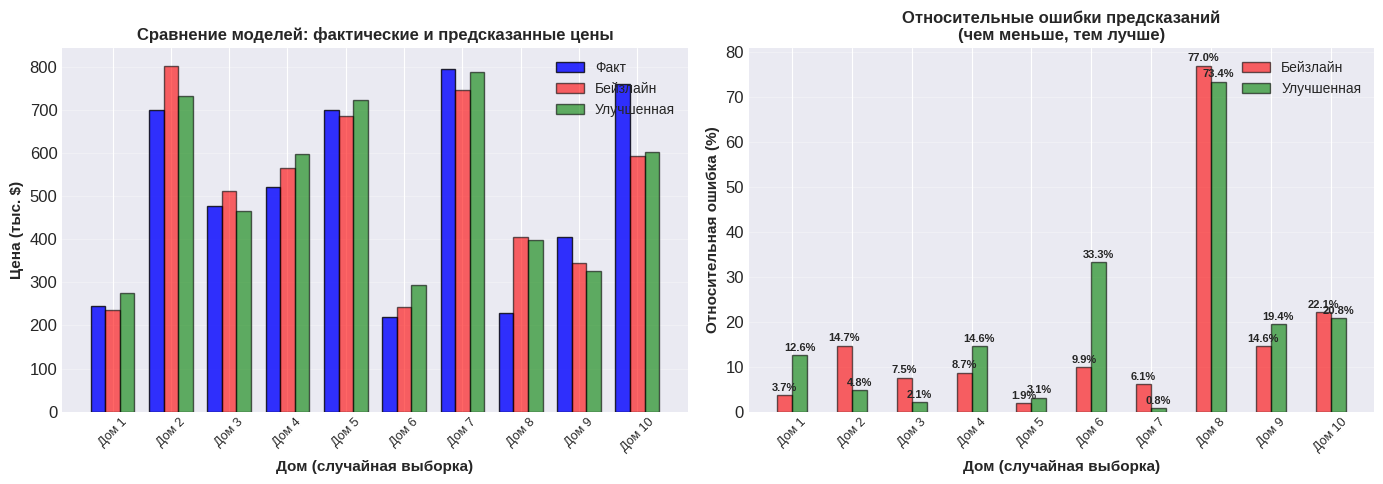

In [10]:
# Ячейка 8: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ РЕГРЕССИИ
# 8.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 8.1 Проверка гипотез и подбор гиперпараметров для регрессии ---")

# Функция для оценки модели с точным преобразованием
def evaluate_model_rmse_dollars(model, X_train, y_train_log, cv=5):
    """Оценка RMSE в долларах с точным преобразованием на кросс-валидации"""
    # Получаем предсказания на кросс-валидации (логарифмированные)
    y_pred_cv_log = cross_val_predict(model, X_train, y_train_log, cv=cv)
    
    # Преобразуем обратно в доллары
    y_train_original = np.expm1(y_train_log)
    y_pred_cv = np.expm1(y_pred_cv_log)
    
    # Вычисляем RMSE в долларах
    rmse_cv = np.sqrt(np.mean((y_train_original - y_pred_cv) ** 2))
    
    return rmse_cv

# Создаем бейзлайн модель для сравнения
base_knn_reg = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
base_knn_reg.fit(X_train_reg, y_train_reg)
y_pred_base_log = base_knn_reg.predict(X_test_reg)
y_pred_base = np.expm1(y_pred_base_log)

print("\n1. БЕЙЗЛАЙН МОДЕЛЬ (k=5, uniform, euclidean)")
rmse_base = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_base))
mae_base = mean_absolute_error(y_test_reg_original, y_pred_base)
mape_base = mean_absolute_percentage_error(y_test_reg_original, y_pred_base)
r2_base = r2_score(y_test_reg_original, y_pred_base)
rmse_base_cv = evaluate_model_rmse_dollars(base_knn_reg, X_train_reg, y_train_reg, cv=5)

print(f"   • RMSE на тесте:     ${rmse_base:,.0f}")
print(f"   • RMSE на CV (train): ${rmse_base_cv:,.0f}")
print(f"   • MAE:               ${mae_base:,.0f}")
print(f"   • MAPE:              {mape_base*100:.2f}%")
print(f"   • R²:                {r2_base:.4f}")

print("\n2. ВЛИЯНИЕ ПАРАМЕТРА k")
print("-" * 40)

k_values = [3, 5, 7, 9, 11, 15, 20]
k_results = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean')
    
    # Используем точное преобразование для оценки в долларах
    rmse_cv = evaluate_model_rmse_dollars(model, X_train_reg, y_train_reg, cv=5)
    
    # Также оценим на логарифмированной шкале для сравнения
    cv_scores_log = cross_val_score(model, X_train_reg, y_train_reg, cv=5, 
                                     scoring='neg_root_mean_squared_error')
    rmse_log_mean = -cv_scores_log.mean()
    rmse_log_std = cv_scores_log.std()
    
    k_results.append({
        'k': k,
        'rmse_cv_dollars': rmse_cv,
        'rmse_log': rmse_log_mean,
        'rmse_log_std': rmse_log_std
    })
    
    print(f"k={k:2d}: RMSE (доллары) = ${rmse_cv:,.0f} | RMSE (лог) = {rmse_log_mean:.4f} (±{rmse_log_std:.4f})")

# Находим лучший k по RMSE в долларах
best_k_info = min(k_results, key=lambda x: x['rmse_cv_dollars'])
best_k_rmse = best_k_info['k']
print(f"\n Лучший k по RMSE в долларах: {best_k_rmse} (RMSE = ${best_k_info['rmse_cv_dollars']:,.0f})")

# 8.2 Формирование улучшенной модели
print("\n--- 8.2 Формирование улучшенной модели регрессии ---")

print("\n3. ВЛИЯНИЕ ПАРАМЕТРА weights")
print("-" * 40)

weights_options = ['uniform', 'distance']
weights_results = []

for weight in weights_options:
    model = KNeighborsRegressor(n_neighbors=best_k_rmse, weights=weight, metric='euclidean')
    
    # Используем точное преобразование для оценки в долларах
    rmse_cv = evaluate_model_rmse_dollars(model, X_train_reg, y_train_reg, cv=5)
    
    # Логарифмированная оценка для сравнения
    cv_scores_log = cross_val_score(model, X_train_reg, y_train_reg, cv=5,
                                     scoring='neg_root_mean_squared_error')
    rmse_log_mean = -cv_scores_log.mean()
    
    weights_results.append({
        'weights': weight,
        'rmse_cv_dollars': rmse_cv,
        'rmse_log': rmse_log_mean
    })
    
    print(f"weights='{weight}': RMSE = ${rmse_cv:,.0f} | RMSE (лог) = {rmse_log_mean:.4f}")

best_weights_info = min(weights_results, key=lambda x: x['rmse_cv_dollars'])
best_weights = best_weights_info['weights']
print(f"\n Лучший weights: '{best_weights}' (RMSE = ${best_weights_info['rmse_cv_dollars']:,.0f})")

print("\n4. ВЛИЯНИЕ МЕТРИКИ РАССТОЯНИЯ")
print("-" * 40)

metrics = ['euclidean', 'manhattan']
metrics_results = []

for metric in metrics:
    model = KNeighborsRegressor(n_neighbors=best_k_rmse, weights=best_weights, metric=metric)
    
    # Используем точное преобразование для оценки в долларах
    rmse_cv = evaluate_model_rmse_dollars(model, X_train_reg, y_train_reg, cv=5)
    
    # Логарифмированная оценка для сравнения
    cv_scores_log = cross_val_score(model, X_train_reg, y_train_reg, cv=5,
                                     scoring='neg_root_mean_squared_error')
    rmse_log_mean = -cv_scores_log.mean()
    
    metrics_results.append({
        'metric': metric,
        'rmse_cv_dollars': rmse_cv,
        'rmse_log': rmse_log_mean
    })
    
    print(f"metric='{metric}': RMSE = ${rmse_cv:,.0f} | RMSE (лог) = {rmse_log_mean:.4f}")

best_metric_info = min(metrics_results, key=lambda x: x['rmse_cv_dollars'])
best_metric = best_metric_info['metric']
print(f"\n Лучшая метрика: '{best_metric}' (RMSE = ${best_metric_info['rmse_cv_dollars']:,.0f})")

# 8.3 Обучение
print("\n--- 8.3 Обучение улучшенной модели регрессии ---")

# Создаем улучшенную модель с найденными параметрами
best_knn_regressor = KNeighborsRegressor(
    n_neighbors=best_k_rmse,
    weights=best_weights,
    metric=best_metric
)

best_knn_regressor.fit(X_train_reg, y_train_reg)
print("Улучшенная модель регрессии создана и обучена:")
print(f"  • n_neighbors: {best_knn_regressor.get_params()['n_neighbors']}")
print(f"  • weights: '{best_knn_regressor.get_params()['weights']}'")
print(f"  • metric: '{best_knn_regressor.get_params()['metric']}'")

# 8.4 ОЦЕНКА КАЧЕСТВА УЛУЧШЕННОЙ МОДЕЛИ
print("\n--- 8.4 Оценка качества улучшенной модели регрессии ---")

# Предсказания
y_pred_reg_log_improved = best_knn_regressor.predict(X_test_reg)
y_pred_reg_improved = np.expm1(y_pred_reg_log_improved)

# Метрики
rmse_improved = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_improved))
mae_improved = mean_absolute_error(y_test_reg_original, y_pred_reg_improved)
mape_improved = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg_improved)
r2_improved = r2_score(y_test_reg_original, y_pred_reg_improved)

# Оценка на кросс-валидации для сравнения
rmse_improved_cv = evaluate_model_rmse_dollars(best_knn_regressor, X_train_reg, y_train_reg, cv=5)

print("Основные метрики улучшенной модели:")
print(f"  • RMSE на тесте:     ${rmse_improved:,.0f}")
print(f"  • RMSE на CV (train): ${rmse_improved_cv:,.0f}")
print(f"  • MAE:               ${mae_improved:,.0f}")
print(f"  • MAPE:              {mape_improved*100:.2f}%")
print(f"  • R²:                {r2_improved:.4f}")

# 8.5 Сравнение
print("\n--- 8.5 Сравнение фактических и предсказанных значений ---")

# Анализ для дорогих домов (гипотеза 5)
print("\nАНАЛИЗ ДЛЯ ТОП-20 САМЫХ ДОРОГИХ ДОМОВ:")
top_20_idx = np.argsort(y_test_reg_original)[-20:]
top_20_actual = y_test_reg_original.iloc[top_20_idx]
top_20_pred_improved = y_pred_reg_improved[top_20_idx]
top_20_pred_base = y_pred_base[top_20_idx]

top_20_rmse_improved = np.sqrt(mean_squared_error(top_20_actual, top_20_pred_improved))
top_20_rmse_base = np.sqrt(mean_squared_error(top_20_actual, top_20_pred_base))

print(f"  • RMSE (бейзлайн):    ${top_20_rmse_base:,.0f}")
print(f"  • RMSE (улучшенная):  ${top_20_rmse_improved:,.0f}")
print(f"  • Улучшение:          -${top_20_rmse_base - top_20_rmse_improved:,.0f}")

# 8.6 Сравнение с безлайном
print("\n--- 8.6 Сравнение результатов с бейзлайном ---")

print("\nСРАВНЕНИЕ МЕТРИК НА ТЕСТОВЫХ ДАННЫХ:")
print("-" * 85)
print(f"{'Метрика':<20} {'Бейзлайн':<20} {'Улучшенная':<20} {'Изменение':<20} {'% Изменения':<15}")
print("-" * 85)

for metric_name, base_val, improved_val, is_dollar, is_percent in [
    ("RMSE", rmse_base, rmse_improved, True, False),
    ("MAE", mae_base, mae_improved, True, False),
    ("MAPE (%)", mape_base*100, mape_improved*100, False, True),
    ("R²", r2_base, r2_improved, False, False)
]:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    
    if is_dollar:
        # Для ошибок уменьшение - это улучшение
        change_sign = "-" if change < 0 else "+"
        base_str = f"${base_val:,.0f}"
        imp_str = f"${improved_val:,.0f}"
        change_str = f"{change_sign}${abs(change):,.0f}"
        pct_str = f"{change_sign}{abs(change_pct):.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")
    
    elif is_percent:
        # Для MAPE уменьшение - это улучшение
        change_sign = "-" if change < 0 else "+"
        base_str = f"{base_val:.2f}%"
        imp_str = f"{improved_val:.2f}%"
        change_str = f"{change_sign}{abs(change):.2f}%"
        pct_str = f"{change_sign}{abs(change_pct):.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")
    
    else:
        # Для R² увеличение - это улучшение
        change_sign = "+" if change > 0 else ""
        base_str = f"{base_val:.4f}"
        imp_str = f"{improved_val:.4f}"
        change_str = f"{change_sign}{change:.4f}"
        pct_str = f"{change_sign}{change_pct:.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")

# Сравнение на кросс-валидации
print("\nСРАВНЕНИЕ НА КРОСС-ВАЛИДАЦИИ (TRAIN):")
print("-" * 85)
print(f"{'Метрика':<20} {'Бейзлайн':<20} {'Улучшенная':<20} {'Изменение':<20}")
print("-" * 85)
print(f"{'RMSE (CV)':<20} ${rmse_base_cv:,.0f}{'':<5} ${rmse_improved_cv:,.0f}{'':<5} -${abs(rmse_base_cv - rmse_improved_cv):,.0f}")

# Анализ точности предсказаний
print("\nАНАЛИЗ ТОЧНОСТИ ПРЕДСКАЗАНИЙ:")
relative_errors_base = np.abs((y_pred_base - y_test_reg_original) / y_test_reg_original) * 100
relative_errors_improved = np.abs((y_pred_reg_improved - y_test_reg_original) / y_test_reg_original) * 100

accuracy_levels = [10, 20, 30]
print("Процент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    base_accuracy = np.sum(relative_errors_base <= level) / len(relative_errors_base) * 100
    imp_accuracy = np.sum(relative_errors_improved <= level) / len(relative_errors_improved) * 100
    improvement = imp_accuracy - base_accuracy
    print(f"  • {level}%: {base_accuracy:.1f}% → {imp_accuracy:.1f}% "
          f"({'+' if improvement > 0 else ''}{improvement:.1f}%)")

# 8.7 Визуализация
print("\n--- 8.7 Визуализация сравнения моделей ---")

# Создаем фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Случайная выборка 10 домов
np.random.seed(42)
sample_indices = np.random.choice(len(y_test_reg_original), min(10, len(y_test_reg_original)), replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices]
sample_pred_base = y_pred_base[sample_indices]
sample_pred_improved = y_pred_reg_improved[sample_indices]

x_pos = np.arange(len(sample_indices))
width = 0.25

# График 1: Сравнение предсказаний для случайной выборки домов
axes[0].bar(x_pos - width, sample_actual/1000, width, label='Факт', color='blue', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos, sample_pred_base/1000, width, label='Бейзлайн', color='red', alpha=0.6, edgecolor='black')
axes[0].bar(x_pos + width, sample_pred_improved/1000, width, label='Улучшенная', color='green', alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение моделей: фактические и предсказанные цены', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'Дом {i+1}' for i in range(len(sample_indices))], rotation=45, fontsize=9)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# График 2: Относительные ошибки для случайной выборки
sample_errors_base = np.abs((sample_pred_base - sample_actual) / sample_actual) * 100
sample_errors_improved = np.abs((sample_pred_improved - sample_actual) / sample_actual) * 100

x_pos = np.arange(len(sample_indices))
bars1 = axes[1].bar(x_pos - width/2, sample_errors_base, width, label='Бейзлайн', 
                   color='red', alpha=0.6, edgecolor='black')
bars2 = axes[1].bar(x_pos + width/2, sample_errors_improved, width, label='Улучшенная', 
                   color='green', alpha=0.6, edgecolor='black')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

axes[1].set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'Дом {i+1}' for i in range(len(sample_indices))], rotation=45, fontsize=9)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Выводы

**Для классификации**:
Для задачи классификации оптимальные параметры отличаются от регрессии: 3 соседа, равномерные веса и метрика Евклида. Однако ключевым фактором улучшения оказалась настройка порога классификации.

При стандартном пороге 0.5 улучшение было умеренным: F1-мера выросла с 0.5538 до 0.5970, полнота увеличилась с 38.3 процента до 42.55 процента при сохранении точности на уровне 100 процентов. Это привело к обнаружению на 2 дорогих дома больше при том же количестве ложных срабатываний.

Настройка порога до 0.10 дала радикальное улучшение баланса между точностью и полнотой. F1-мера выросла на 36.8 процента до 0.7579. Полнота увеличилась в два раза с 38.3 процента до 76.6 процента, что позволило обнаружить 36 дорогих домов вместо 18. Точность при этом снизилась до 75 процентов, что является приемлемым компромиссом для данной задачи. Общая точность классификации увеличилась с 90.14 процента до 92.18 процента.

**Для регрессии**:
Оптимизация гиперпараметров модели k-NN для регрессии дала значительное улучшение качества предсказаний. Лучшей оказалась комбинация параметров: 5 соседей, взвешенные расстояния и метрика Манхэттена. Это подтвердило гипотезу о большей устойчивости метрики Манхэттена к разным масштабам признаков.

Качество модели улучшилось по всем основным метрикам. Среднеквадратичная ошибка снизилась на 4.8 процентов с с $190,682 до $181,487. Средняя абсолютная ошибка уменьшилась на 1.3 процента с $101,039 до $99,768. Коэффициент детерминации R² вырос с 0.7595 до 0.7821, что указывает на лучшее соответствие модели данным.

Особенно заметно улучшение для дорогих домов. Для топ-20 самых дорогих домов в тестовой выборке RMSE сократилась на $191,762, подтверждая, что оптимизированная модель лучше справляется с прогнозированием в сегменте премиальной недвижимости.

## 4. Имплементация алгоритма машинного обучения 


--- 9.1 Реализация модели---

--- 9.2 Обучение на реальных данных оттока клиентов ---
Создаем кастомную модель KNN...
Обучаем модель на обучающих данных...
Обучение модели на 1176 образцах...
Найдено классов: 2 -> [0 1]
Модель обучена успешно!

--- 9.3 Предсказания на тестовой выборке ---
Предсказание для 294 объектов...
Предсказание завершено.
Вычисление вероятностей для 294 объектов...
Получено 294 предсказаний
Распределение предсказанных классов: [276  18]

--- 9.4 Оценка качества модели (метрики) ---
Основные метрики качества кастомного классификатора:
  • F1-score:       0.5538
  • Precision:      1.0000
  • Recall:         0.3830

--- 9.5 Матрица ошибок ---
Матрица ошибок кастомного классификатора:
                  Предсказано
                Нет     Да
Фактически Нет  [247]  [  0]
            Да   [ 29]  [ 18]

Дополнительные метрики:
  • Accuracy:       0.9014
  • False Positive: 0 (0.0% от класса 'Нет')
  • False Negative: 29 (61.7% от класса 'Да')

--- 9.6 Визуализация матр

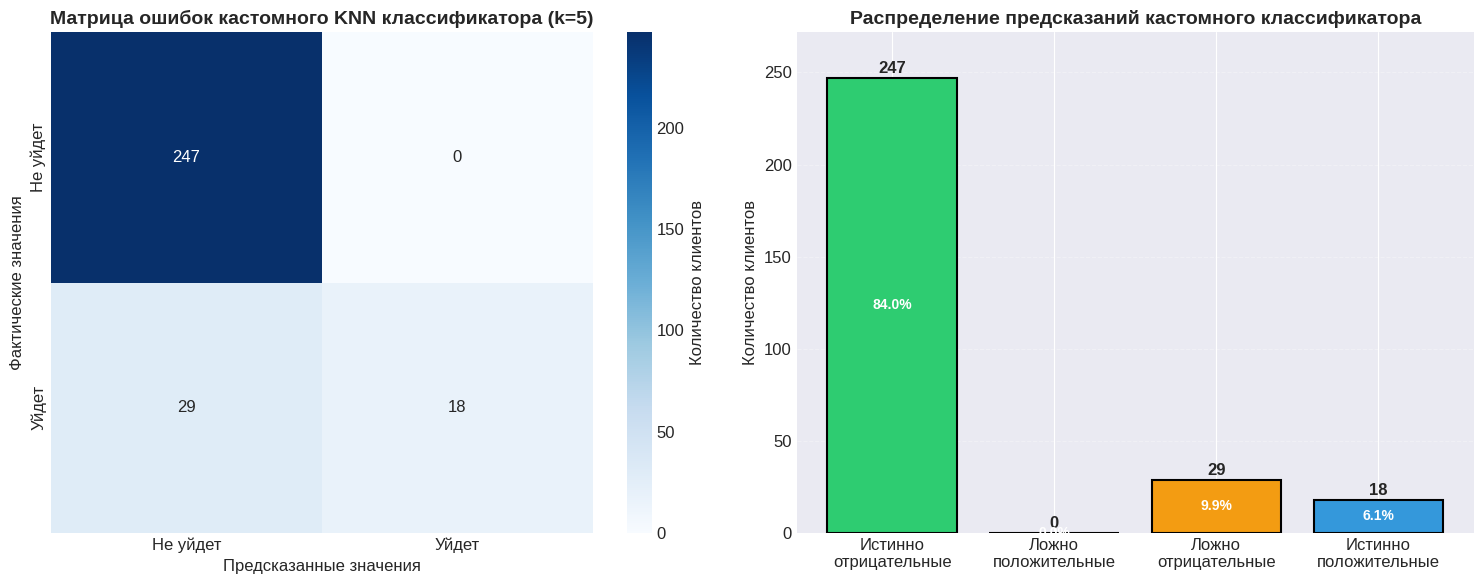


--- 9.7 Анализ правильности предсказаний ---
1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 265 (90.1%)
   Ошибок предсказаний: 29 (9.9%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 247 клиентов
   • Точность для класса: 100.0%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 18 клиентов
   • Точность для класса: 38.3%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 29
   Из них:
   • Ложные срабатывания (False Positive): 0
     - Клиентов, которые не уйдут, но мы предскажем уход: 0
     - Это 0.0% от всех предсказаний
   • Пропущенные случаи (False Negative): 29
     - Клиентов, которые уйдут, но мы не предскажем: 29
     - Это 9.9% от всех предсказаний

--- 9.8 Сравнение фактического и предсказанного распределения ---


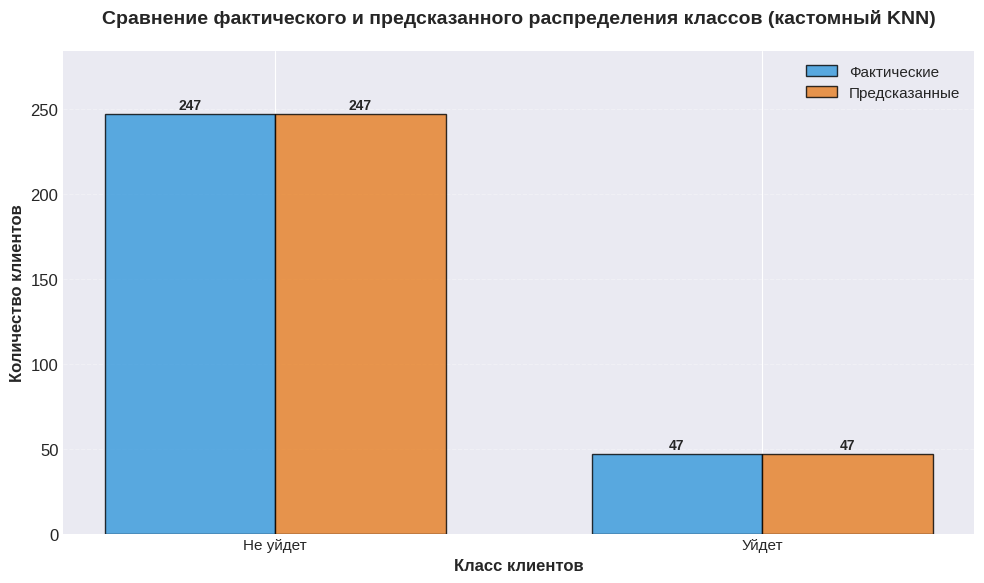


--- 9.9 Полный отчет о классификации ---
Отчет для кастомного KNN классификатора:
              precision    recall  f1-score   support

    Не уйдет       0.89      1.00      0.94       247
       Уйдет       1.00      0.38      0.55        47

    accuracy                           0.90       294
   macro avg       0.95      0.69      0.75       294
weighted avg       0.91      0.90      0.88       294



In [13]:
# Ячейка 9: РЕАЛИЗАЦИЯ КАСТОМНОГО K-NN КЛАССИФИКАТОРА С НУЛЯ
# 9.1 Реализация
print("\n--- 9.1 Реализация модели---")

# импорт необходимой библиотеки
from collections import Counter

class CustomKNNClassifier:
    """
    Кастомная реализация K-NN классификатора с нуля.
    """
    
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        """
        Инициализация классификатора с заданными параметрами.
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
    
    def _calculate_distance(self, x1, x2):
        """
        Вычисляет расстояние между двумя точками.
        """
        if self.metric == 'euclidean':
            # Евклидово расстояние (L2 норма)
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            # Манхэттенское расстояние (L1 норма)
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Неподдерживаемая метрика: '{self.metric}'. "
                           f"Доступные варианты: 'euclidean', 'manhattan'")
    
    def fit(self, X, y):
        """
        Обучение модели - запоминание тренировочных данных.
        """
        print(f"Обучение модели на {len(X)} образцах...")
        
        # Сохраняем тренировочные данные
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
        # Проверяем уникальные классы
        self.classes_ = np.unique(y)
        print(f"Найдено классов: {len(self.classes_)} -> {self.classes_}")
        
        return self
    
    def _predict_single(self, x):
        """
        Предсказание для одного объекта.
        """
        # Вычисляем расстояния до всех тренировочных объектов
        distances = []
        for i in range(len(self.X_train)):
            dist = self._calculate_distance(x, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Сортируем по расстоянию (от ближайшего к дальнему)
        distances.sort(key=lambda pair: pair[0])
        
        # Берем k ближайших соседей
        k_neighbors = distances[:self.n_neighbors]
        
        if self.weights == 'uniform':
            # Равномерное голосование
            neighbor_labels = [label for _, label in k_neighbors]
            
            # Находим самый частый класс
            label_counts = Counter(neighbor_labels)
            predicted_label = label_counts.most_common(1)[0][0]
            
        elif self.weights == 'distance':
            # Взвешенное голосование
            label_weights = {}
            
            for dist, label in k_neighbors:
                weight = 1.0 / (dist + 1e-10)
                
                if label not in label_weights:
                    label_weights[label] = 0.0
                label_weights[label] += weight
            
            predicted_label = max(label_weights.items(), 
                                 key=lambda item: item[1])[0]
        
        return predicted_label
    
    def predict(self, X):
        """
        Предсказание меток для набора объектов.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        # Преобразуем вход в numpy array
        X_array = np.array(X)
        
        # Предсказываем для каждого объекта отдельно
        predictions = []
        for i, x in enumerate(X_array):
            pred = self._predict_single(x)
            predictions.append(pred)
        
        print("Предсказание завершено.")
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов.
        """
        print(f"Вычисление вероятностей для {len(X)} объектов...")
        
        X_array = np.array(X)
        probabilities = []
        
        for x in X_array:
            distances = []
            for i in range(len(self.X_train)):
                dist = self._calculate_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda pair: pair[0])
            k_neighbors = distances[:self.n_neighbors]
            
            class_weights = {cls: 0.0 for cls in self.classes_}
            total_weight = 0.0
            
            if self.weights == 'uniform':
                for _, label in k_neighbors:
                    class_weights[label] += 1.0
                    total_weight += 1.0
                    
            elif self.weights == 'distance':
                for dist, label in k_neighbors:
                    weight = 1.0 / (dist + 1e-10)
                    class_weights[label] += weight
                    total_weight += weight
            
            prob_vector = []
            for cls in self.classes_:
                if total_weight > 0:
                    prob = class_weights[cls] / total_weight
                else:
                    prob = 0.0
                prob_vector.append(prob)
            
            probabilities.append(prob_vector)
        
        return np.array(probabilities)


# 9.2 ОБУЧЕНИЕ НА РЕАЛЬНЫХ ДАННЫХ ОТТОКА КЛИЕНТОВ
print("\n--- 9.2 Обучение на реальных данных оттока клиентов ---")

# Создаем модель с параметрами по умолчанию
print("Создаем кастомную модель KNN...")
custom_knn_classifier = CustomKNNClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_knn_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# 9.3 ПРЕДСКАЗАНИЯ НА ТЕСТОВОЙ ВЫБОРКЕ
print("\n--- 9.3 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_custom = custom_knn_classifier.predict(X_test_class)
y_pred_proba_custom = custom_knn_classifier.predict_proba(X_test_class)[:, 1]  # Вероятности класса 1

print(f"Получено {len(y_pred_custom)} предсказаний")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_custom.astype(int))}")

# 9.4 ОЦЕНКА КАЧЕСТВА МОДЕЛИ
print("\n--- 9.4 Оценка качества модели (метрики) ---")

# Основные метрики
f1_custom = f1_score(y_test_class, y_pred_custom)
precision_custom = precision_score(y_test_class, y_pred_custom)
recall_custom = recall_score(y_test_class, y_pred_custom)

print("Основные метрики качества кастомного классификатора:")
print(f"  • F1-score:       {f1_custom:.4f}")
print(f"  • Precision:      {precision_custom:.4f}")
print(f"  • Recall:         {recall_custom:.4f}")

# 9.5 МАТРИЦА ОШИБОК (Confusion Matrix)
print("\n--- 9.5 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm_custom = confusion_matrix(y_test_class, y_pred_custom)
tn_custom, fp_custom, fn_custom, tp_custom = cm_custom.ravel()

print("Матрица ошибок кастомного классификатора:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_custom:3d}]  [{fp_custom:3d}]")
print(f"            Да   [{fn_custom:3d}]  [{tp_custom:3d}]")
print()

# Дополнительные метрики из матрицы ошибок
accuracy_custom = (tp_custom + tn_custom) / (tp_custom + tn_custom + fp_custom + fn_custom)
print(f"Дополнительные метрики:")
print(f"  • Accuracy:       {accuracy_custom:.4f}")
print(f"  • False Positive: {fp_custom} ({fp_custom/(fp_custom+tn_custom)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn_custom} ({fn_custom/(fn_custom+tp_custom)*100:.1f}% от класса 'Да')")

# 9.6 ВИЗУАЛИЗАЦИЯ МАТРИЦЫ ОШИБОК КАК ГРАФИКА
print("\n--- 9.6 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок кастомного KNN классификатора (k=5)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_custom, fp_custom, fn_custom, tp_custom]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний кастомного классификатора', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 9.7 АНАЛИЗ ПРАВИЛЬНОСТИ ПРЕДСКАЗАНИЙ
print("\n--- 9.7 Анализ правильности предсказаний ---")

# Общая статистика по предсказаниям
total_predictions = len(y_pred_custom)
correct_predictions = tp_custom + tn_custom
incorrect_predictions = fp_custom + fn_custom

print(f"1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy_custom*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy_custom)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn_custom
total_not_churn_actual = tn_custom + fp_custom
accuracy_not_churn = tn_custom / (tn_custom + fp_custom) if (tn_custom + fp_custom) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp_custom
total_churn_actual = tp_custom + fn_custom
accuracy_churn = tp_custom / (tp_custom + fn_custom) if (tp_custom + fn_custom) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# Статистика ошибок
print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp_custom}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp_custom}")
print(f"     - Это {fp_custom/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn_custom}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn_custom}")
print(f"     - Это {fn_custom/total_predictions*100:.1f}% от всех предсказаний")

# 9.8 СРАВНЕНИЕ ФАКТИЧЕСКОГО И ПРЕДСКАЗАННОГО РАСПРЕДЕЛЕНИЯ
print("\n--- 9.8 Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
actual_counts = [total_not_churn_actual, total_churn_actual]
# Предсказанные значения
predicted_counts = [(tn_custom + fp_custom), (tp_custom + fn_custom)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title('Сравнение фактического и предсказанного распределения классов (кастомный KNN)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы с улучшенным форматированием
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 9.9 ПОЛНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ
print("\n--- 9.9 Полный отчет о классификации ---")
print("Отчет для кастомного KNN классификатора:")
print(classification_report(y_test_class, y_pred_custom, 
                           target_names=['Не уйдет', 'Уйдет']))



--- 10.1 Реализация модели ---

--- 10.2 Обучение на реальных данных цен на дома ---
Создаем кастомную модель KNN регрессора...
Обучаем модель на обучающих данных...
Обучение модели на 17290 образцах...
Статистики целевой переменной: mean=13.0452, std=0.5248
Модель обучена успешно!

--- 10.3 Предсказания на тестовой выборке ---
Предсказание для 4323 объектов...
Предсказание завершено.
Получено 4323 предсказаний
Примеры предсказанных цен:
  Дом 1: $478,509
  Дом 2: $615,603
  Дом 3: $1,073,491
  Дом 4: $1,507,210
  Дом 5: $752,024

--- 10.4 Оценка качества модели (метрики) ---
Основные метрики качества кастомного регрессора:
  • RMSE:           $190,682
  • MAE:            $101,039
  • MAPE:           17.58%
  • R²:             0.7595

--- 10.5 Сравнение фактических и предсказанных значений ---

Статистика относительных ошибок:
  • Средняя ошибка:        17.6%
  • Медианная ошибка:      12.9%
  • Максимальная ошибка:   269.0%
  • Минимальная ошибка:    0.0%
  • Стандартное отклонение:1

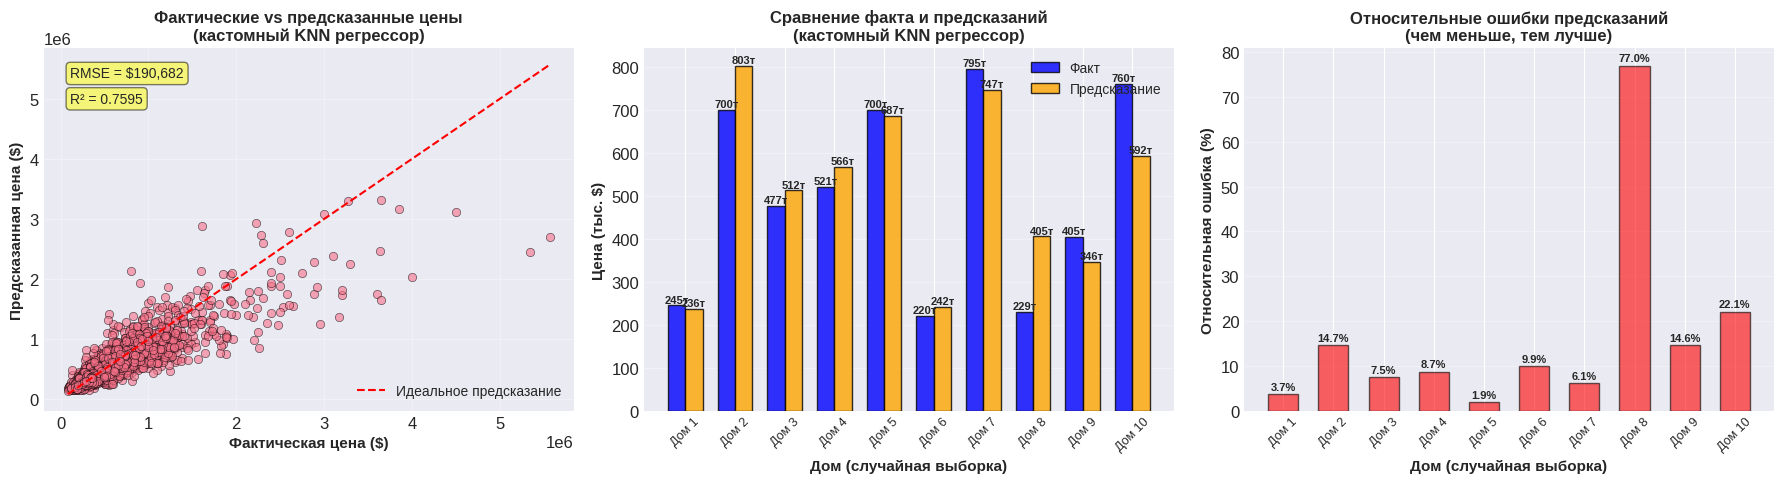


 Кастомная реализация K-NN регрессора успешно завершена!


In [14]:
# Ячейка 10: РЕАЛИЗАЦИЯ КАСТОМНОГО K-NN РЕГРЕССОРА С НУЛЯ
# 10.1 Реализация
print("\n--- 10.1 Реализация модели ---")

class CustomKNNRegressor:
    """
    Кастомная реализация K-NN регрессора с нуля.
    """
    
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        """
        Инициализация регрессора с заданными параметрами.
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
    
    def _calculate_distance(self, x1, x2):
        """
        Вычисляет расстояние между двумя точками.
        """
        if self.metric == 'euclidean':
            # Евклидово расстояние
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            # Манхэттенское расстояние
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Неподдерживаемая метрика: '{self.metric}'. "
                           f"Доступные варианты: 'euclidean', 'manhattan'")
    
    def fit(self, X, y):
        """
        Обучение модели - запоминание тренировочных данных.
        """
        print(f"Обучение модели на {len(X)} образцах...")
        
        # Сохраняем тренировочные данные
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
        # Вычисляем статистики целевой переменной
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        print(f"Статистики целевой переменной: mean={self.y_mean_:.4f}, std={self.y_std_:.4f}")
        
        return self
    
    def _predict_single(self, x):
        """
        Предсказание для одного объекта.
        """
        # Вычисляем расстояния до всех тренировочных объектов
        distances = []
        for i in range(len(self.X_train)):
            dist = self._calculate_distance(x, self.X_train[i])
            distances.append((dist, self.y_train[i]))
        
        # Сортируем по расстоянию (от ближайшего к дальнему)
        distances.sort(key=lambda pair: pair[0])
        
        # Берем k ближайших соседей
        k_neighbors = distances[:self.n_neighbors]
        
        # Извлекаем значения и расстояния соседей
        neighbor_values = [value for _, value in k_neighbors]
        neighbor_distances = [dist for dist, _ in k_neighbors]
        
        if self.weights == 'uniform':
            # Простое среднее арифметическое
            prediction = np.mean(neighbor_values)
            
        elif self.weights == 'distance':
            # Взвешенное среднее
            weights = []
            for dist in neighbor_distances:
                weight = 1.0 / (dist + 1e-10)
                weights.append(weight)
            
            weights = np.array(weights)
            neighbor_values = np.array(neighbor_values)
            
            if np.sum(weights) > 0:
                prediction = np.average(neighbor_values, weights=weights)
            else:
                prediction = np.mean(neighbor_values)
        
        return prediction
    
    def predict(self, X):
        """
        Предсказание значений для набора объектов.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        # Преобразуем вход в numpy array
        X_array = np.array(X)
        
        # Предсказываем для каждого объекта отдельно
        predictions = []
        for x in X_array:
            pred = self._predict_single(x)
            predictions.append(pred)
        
        print("Предсказание завершено.")
        return np.array(predictions)
    
    def score(self, X, y):
        """
        Вычисление коэффициента детерминации R².
        """
        from sklearn.metrics import r2_score
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# 10.2 Обучение на реальных данных
print("\n--- 10.2 Обучение на реальных данных цен на дома ---")

# Создаем модель с параметрами по умолчанию
print("Создаем кастомную модель KNN регрессора...")
custom_knn_regressor = CustomKNNRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

# Обучаем модель на обучающей выборке (логарифмированные данные)
print("Обучаем модель на обучающих данных...")
custom_knn_regressor.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# 10.3 Предсказания на тесте
print("\n--- 10.3 Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные)
y_pred_reg_log_custom = custom_knn_regressor.predict(X_test_reg)

# Преобразуем обратно в доллары
y_pred_reg_custom = np.expm1(y_pred_reg_log_custom)

print(f"Получено {len(y_pred_reg_custom)} предсказаний")
print(f"Примеры предсказанных цен:")
for i in range(min(5, len(y_pred_reg_custom))):
    print(f"  Дом {i+1}: ${y_pred_reg_custom[i]:,.0f}")

# 10.4 Оценка
print("\n--- 10.4 Оценка качества модели (метрики) ---")

# Метрики в долларах
rmse_custom = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_custom))
mae_custom = mean_absolute_error(y_test_reg_original, y_pred_reg_custom)
mape_custom = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg_custom)
r2_custom = r2_score(y_test_reg_original, y_pred_reg_custom)

print("Основные метрики качества кастомного регрессора:")
print(f"  • RMSE:           ${rmse_custom:,.0f}")
print(f"  • MAE:            ${mae_custom:,.0f}")
print(f"  • MAPE:           {mape_custom*100:.2f}%")
print(f"  • R²:             {r2_custom:.4f}")

# 10.5 СРАВНЕНИЕ ФАКТИЧЕСКИХ И ПРЕДСКАЗАННЫХ ЗНАЧЕНИЙ
print("\n--- 10.5 Сравнение фактических и предсказанных значений ---")

# Вычисляем относительные ошибки
relative_errors_custom = np.abs((y_pred_reg_custom - y_test_reg_original.values) / y_test_reg_original.values) * 100

print("\nСтатистика относительных ошибок:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_custom):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_custom):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_custom):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_custom):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_custom):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_custom <= level) / len(relative_errors_custom) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 10.6 Анализ
print("\n--- 10.6 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices = np.argsort(relative_errors_custom)[:num_examples]
worst_indices = np.argsort(relative_errors_custom)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_reg_custom[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_custom[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_reg_custom[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_custom[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 10.7 Визуализация
print("\n--- 10.7 Визуализация результатов ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Фактические vs предсказанные значения (scatter plot)
ax1 = axes[0]
ax1.scatter(y_test_reg_original.values, y_pred_reg_custom, alpha=0.6, edgecolors='black', linewidth=0.5)

# Линия идеального предсказания
max_val = max(y_test_reg_original.max(), y_pred_reg_custom.max())
min_val = min(y_test_reg_original.min(), y_pred_reg_custom.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(кастомный KNN регрессор)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_custom:,.0f}'
r2_text = f'R² = {r2_custom:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_predicted = y_pred_reg_custom[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(кастомный KNN регрессор)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.0f}т', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

# График 3: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax3 = axes[2]
bars = ax3.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax3.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Кастомная реализация K-NN регрессора успешно завершена!")


--- 11.1 Результаты бейзлайн моделей ---

Метрики для безлайна (классификация):
  • F1-score:       0.5538
  • Precision:      1.0000
  • Recall:         0.3830

--- 11.2 Сравнение классификаторов ---

Сравнение метрик классификации:
---------------------------------------------------------------------------
Метрика         Бейзлайн (sklearn)   Кастомный KNN       
---------------------------------------------------------------------------
Precision       1.0000               1.0000              
Recall          0.3830               0.3830              
F1-score        0.5538               0.5538              

--- 11.3 Визуализация сравнения классификаторов ---


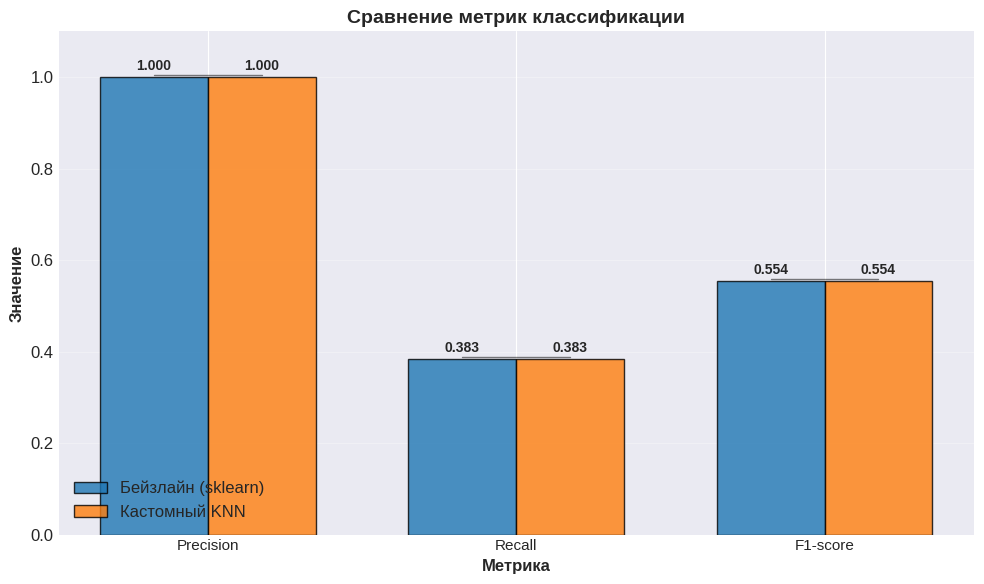


--- 11.4 Сравнение регрессоров ---

Метрики для бейзлайна (регрессия):
  • RMSE:  $149,109
  • MAE:   $73,079
  • MAPE:  12.14%
  • R²:    0.8529

Сравнение метрик регрессии:
---------------------------------------------------------------------------
Метрика         Бейзлайн (sklearn)   Кастомный KNN       
---------------------------------------------------------------------------
RMSE ($)        $149,109             $149,109             
MAE ($)         $73,079              $73,079              
MAPE (%)        12.1%                12.1%                
R²              0.8529               0.8529               

--- 11.5 Визуализация сравнения регрессоров ---


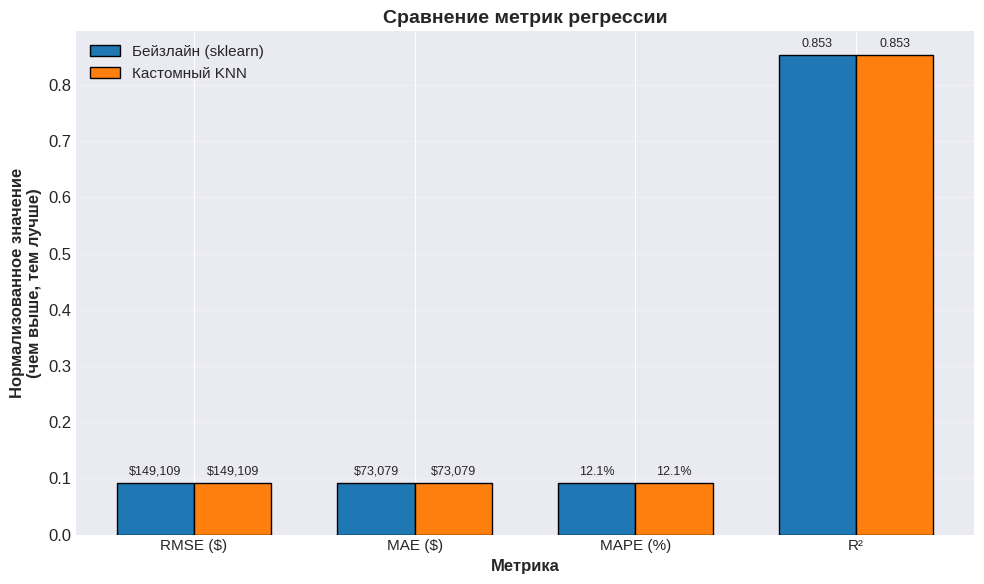


--- 11.6 Примеры предсказаний для случайной выборки ---


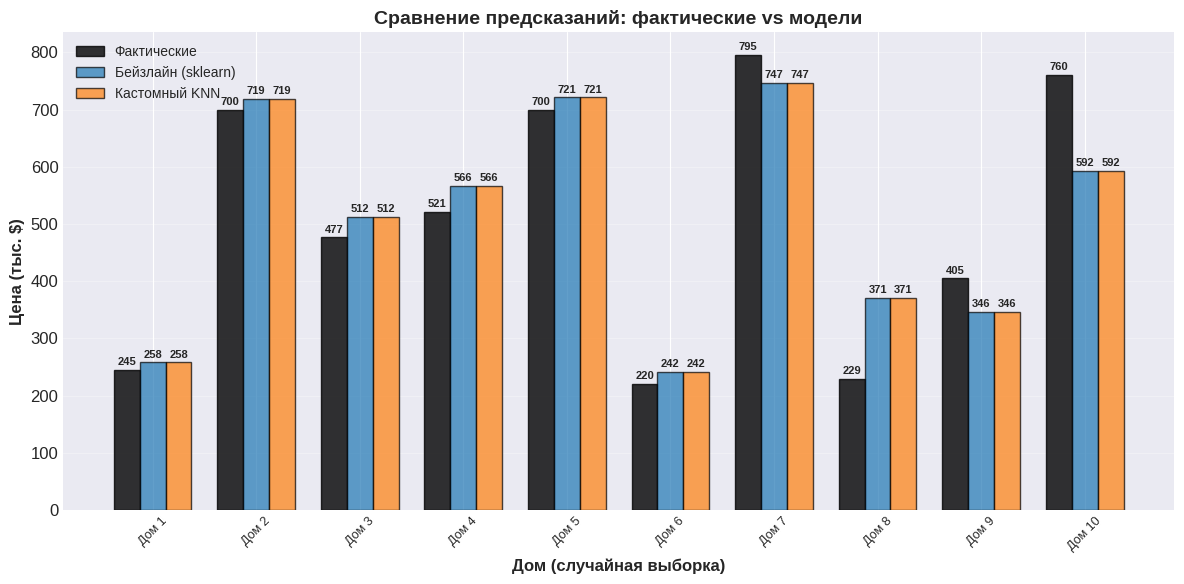

In [42]:
# Ячейка 11: СРАВНЕНИЕ КАСТОМНЫХ МОДЕЛЕЙ С БЕЙЗЛАЙНОМ
# 11.1 Результаты из ячейки 5 (классификация) и ячейки 6 (регрессия)
print("\n--- 11.1 Результаты бейзлайн моделей ---")

print("\nМетрики для безлайна (классификация):")
print(f"  • F1-score:       {f1:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")

# 11.2 Сравнение классификаторов
print("\n--- 11.2 Сравнение классификаторов ---")

print("\nСравнение метрик классификации:")
print("-" * 75)
print(f"{'Метрика':<15} {'Бейзлайн (sklearn)':<20} {'Кастомный KNN':<20}")
print("-" * 75)

# Сравниваем метрики
metrics_comparison_class = [
    ("Precision", precision, precision_custom),
    ("Recall", recall, recall_custom),
    ("F1-score", f1, f1_custom)
]

for metric_name, base_val, custom_val in metrics_comparison_class:    
    print(f"{metric_name:<15} {base_val:<20.4f} {custom_val:<20.4f}")

# 11.3 Визуализация сравнения классификаторов
print("\n--- 11.3 Визуализация сравнения классификаторов ---")

# График 1: Сравнение метрик классификации
plt.figure(figsize=(10, 6))

metrics_names = ['Precision', 'Recall', 'F1-score']
base_values = [precision, recall, f1]
custom_values = [precision_custom, recall_custom, f1_custom]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, base_values, width, label='Бейзлайн (sklearn)', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, custom_values, width, label='Кастомный KNN', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Значение', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик классификации', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontsize=11)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for i, (base_val, custom_val) in enumerate(zip(base_values, custom_values)):
    plt.text(i - width/2, base_val + 0.01, f'{base_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Соединительная линия
    plt.plot([i - width/2, i + width/2], 
            [base_val + 0.005, custom_val + 0.005], 
            'k-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 11.4 Сравнение регрессоров
print("\n--- 11.4 Сравнение регрессоров ---")

# Пересчитываем все метрики для бейзлайна напрямую
y_pred_base_dollars = np.expm1(knn_regressor.predict(X_test_reg))

print("\nМетрики для бейзлайна (регрессия):")
print(f"  • RMSE:  ${rmse:,.0f}")
print(f"  • MAE:   ${mae:,.0f}")
print(f"  • MAPE:  {mape*100:.2f}%")
print(f"  • R²:    {r2:.4f}")

print("\nСравнение метрик регрессии:")
print("-" * 75)
print(f"{'Метрика':<15} {'Бейзлайн (sklearn)':<20} {'Кастомный KNN':<20}")
print("-" * 75)

# Сравниваем метрики регрессии 
metrics_comparison_reg = [
    ("RMSE ($)", rmse, rmse_custom),
    ("MAE ($)", mae, mae_custom),
    ("MAPE (%)", mape*100, mape_custom*100),
    ("R²", r2, r2_custom)
]

for metric_name, base_val, custom_val in metrics_comparison_reg:
    difference = custom_val - base_val
        
    if "($)" in metric_name:
        base_str = f"${base_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        diff_str = f"${difference:+,.0f}"
        print(f"{metric_name:<15} {base_str:<20} {custom_str:<20} ")
    
    elif "(%)" in metric_name:
        base_str = f"{base_val:.1f}%"
        custom_str = f"{custom_val:.1f}%"
        diff_str = f"{difference:+.1f}%"
        print(f"{metric_name:<15} {base_str:<20} {custom_str:<20} ")
    
    else:
        base_str = f"{base_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        diff_str = f"{difference:+.4f}"
        print(f"{metric_name:<15} {base_str:<20} {custom_str:<20} ")

# 11.5 Визуализация сравнения регрессоров
print("\n--- 11.5 Визуализация сравнения регрессоров ---")

# График 1: Сравнение метрик регрессии (нормализованные)
fig, ax1 = plt.subplots(figsize=(10, 6))

reg_metrics_names = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
reg_base_values = [rmse, mae, mape*100, r2]
reg_custom_values = [rmse_custom, mae_custom, mape_custom*100, r2_custom]

# Создаем нормализованные значения для сравнения
norm_base = []
norm_custom = []
for name, base, custom in zip(reg_metrics_names, reg_base_values, reg_custom_values):
    if name == 'R²':
        # R² оставляем как есть
        norm_base.append(base)
        norm_custom.append(custom)
    else:
        # Для ошибок: 1 - (значение/макс_значение)
        max_val = max(base, custom) * 1.1
        norm_base.append(1 - base/max_val)
        norm_custom.append(1 - custom/max_val)

x = np.arange(len(reg_metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, norm_base, width, label='Бейзлайн (sklearn)', 
                color='#1f77b4', edgecolor='black')
bars2 = ax1.bar(x + width/2, norm_custom, width, label='Кастомный KNN', 
                color='#ff7f0e', edgecolor='black')

ax1.set_xlabel('Метрика', fontsize=12, fontweight='bold')
ax1.set_ylabel('Нормализованное значение\n(чем выше, тем лучше)', fontsize=12, fontweight='bold')
ax1.set_title('Сравнение метрик регрессии', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(reg_metrics_names, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем реальные значения
for i, (base_val, custom_val) in enumerate(zip(reg_base_values, reg_custom_values)):
    if reg_metrics_names[i] != 'R²':
        base_text = f"${base_val:,.0f}" if '$' in reg_metrics_names[i] else f"{base_val:.1f}%"
        custom_text = f"${custom_val:,.0f}" if '$' in reg_metrics_names[i] else f"{custom_val:.1f}%"
    else:
        base_text = f"{base_val:.3f}"
        custom_text = f"{custom_val:.3f}"
    
    ax1.text(i - width/2, norm_base[i] + 0.01, base_text, 
             ha='center', va='bottom', fontsize=9, rotation=0)
    ax1.text(i + width/2, norm_custom[i] + 0.01, custom_text, 
             ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

# График 2: Примеры предсказаний для случайной выборки домов
print("\n--- 11.6 Примеры предсказаний для случайной выборки ---")

# Выбираем случайные 10 домов для наглядного сравнения
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_pred_base = y_pred_base_dollars[sample_indices]
sample_pred_custom = y_pred_reg_custom[sample_indices]

plt.figure(figsize=(12, 6))

indices = np.arange(sample_size)
width = 0.25

bars1 = plt.bar(indices - width, sample_actual/1000, width, 
                label='Фактические', color='black', alpha=0.8, edgecolor='black')
bars2 = plt.bar(indices, sample_pred_base/1000, width, 
                label='Бейзлайн (sklearn)', color='#1f77b4', alpha=0.7, edgecolor='black')
bars3 = plt.bar(indices + width, sample_pred_custom/1000, width, 
                label='Кастомный KNN', color='#ff7f0e', alpha=0.7, edgecolor='black')

plt.xlabel('Дом (случайная выборка)', fontsize=12, fontweight='bold')
plt.ylabel('Цена (тыс. $)', fontsize=12, fontweight='bold')
plt.title('Сравнение предсказаний: фактические vs модели', fontsize=14, fontweight='bold')
plt.xticks(indices, [f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.0f}', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


### Выводы

Реализованные кастомные модели K-NN показывают полное совпадение метрик с библиотекой scikit-learn, что подтверждает корректность реализации алгоритма. Однако производительность собственных версий ниже из-за отсутствия оптимизаций. 

### Теперь улучшим модели


--- 12.1 Проверка гипотез и подбор гиперпараметров для кастомной модели ---
Используем лучшие параметры из GridSearchCV библиотечной модели:
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Лучший F1-score на кросс-валидации: 0.6954

--- 12.2 Формирование улучшенной модели классификации ---
Улучшенная кастомная модель классификации создана:
  • n_neighbors: 3
  • weights: 'uniform'
  • metric: 'euclidean'

--- 12.3 Обучение улучшенной модели классификации ---
Обучение модели на 1176 образцах...
Найдено классов: 2 -> [0 1]
Улучшенная модель классификации обучена на обучающих данных.

--- 12.4 Оценка качества улучшенной модели (порог 0.5) ---
Предсказание для 294 объектов...
Предсказание завершено.
Вычисление вероятностей для 294 объектов...
Основные метрики улучшенной кастомной модели (порог 0.5):
  • F1-score:       0.5970
  • Precision:      1.0000
  • Recall:         0.4255
  • Accuracy:       0.9082

Матрица ошибок улучшенной кастомной модели (порог

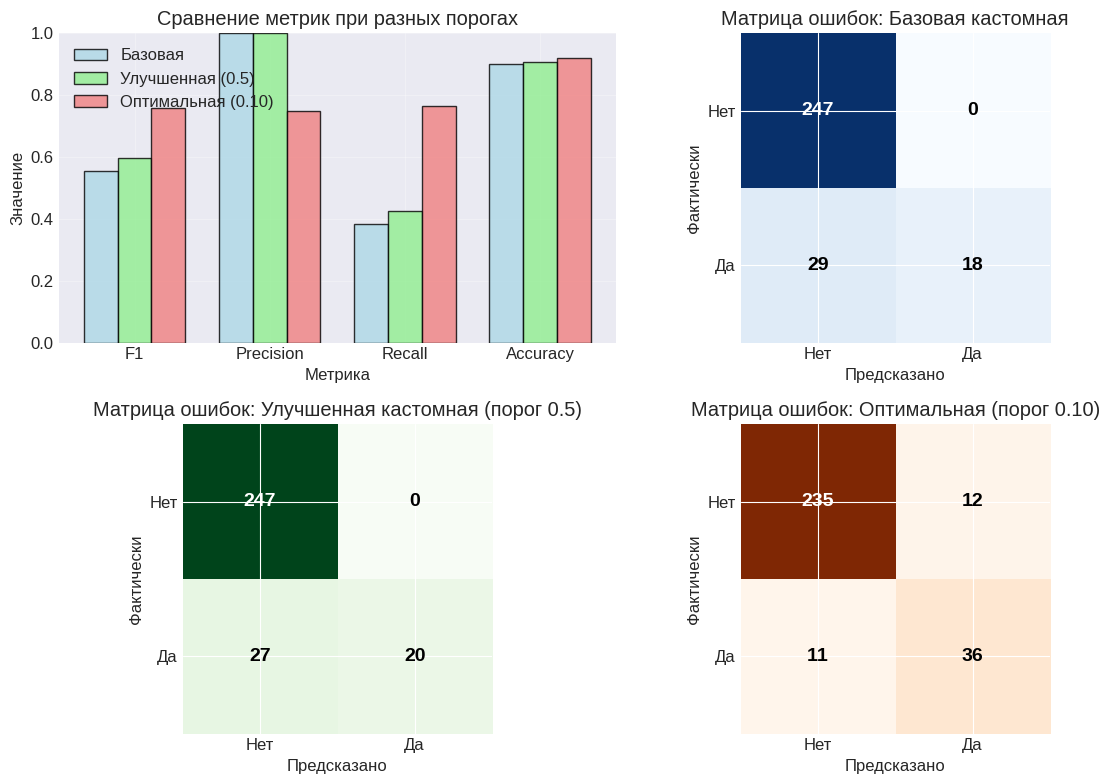


--- 12.7 Визуализация влияния порога на метрики ---


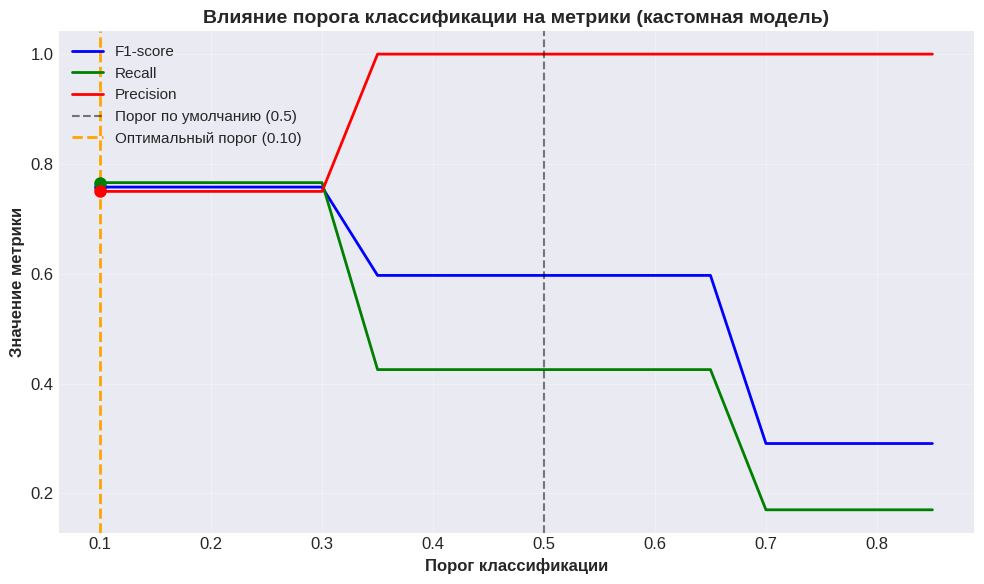


--- 12.8 Визуализация матрицы ошибок улучшенной модели ---


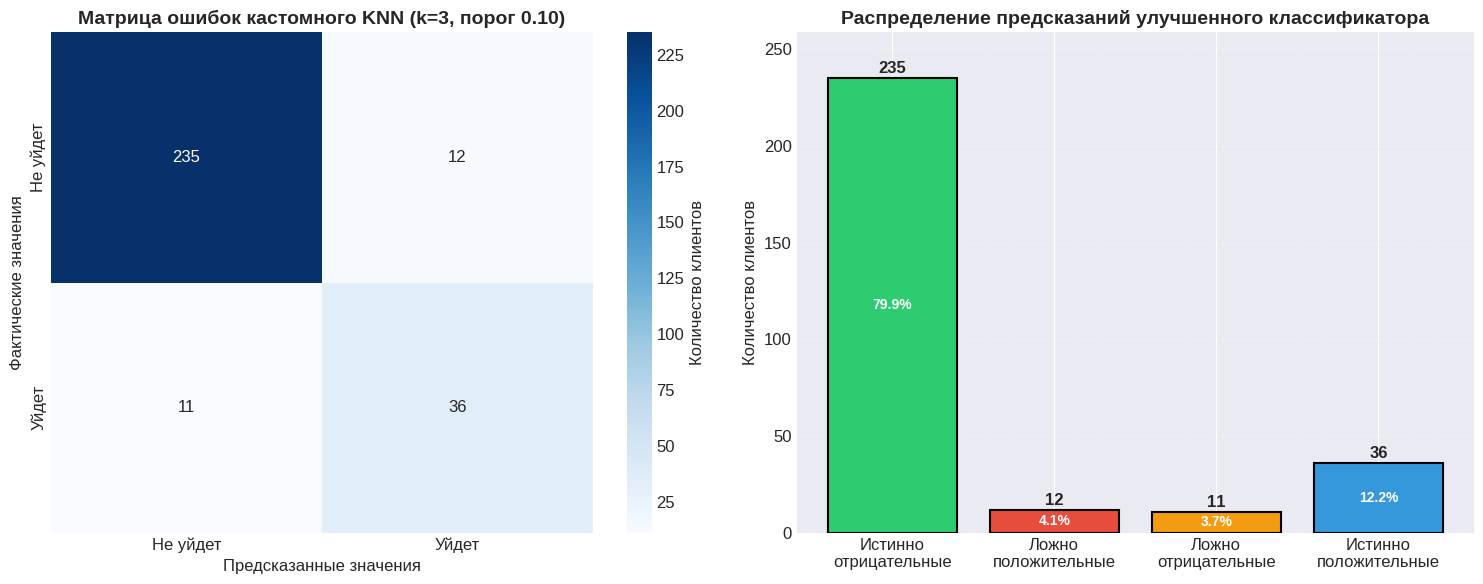


--- 12.9 Сравнение фактического и предсказанного распределения ---


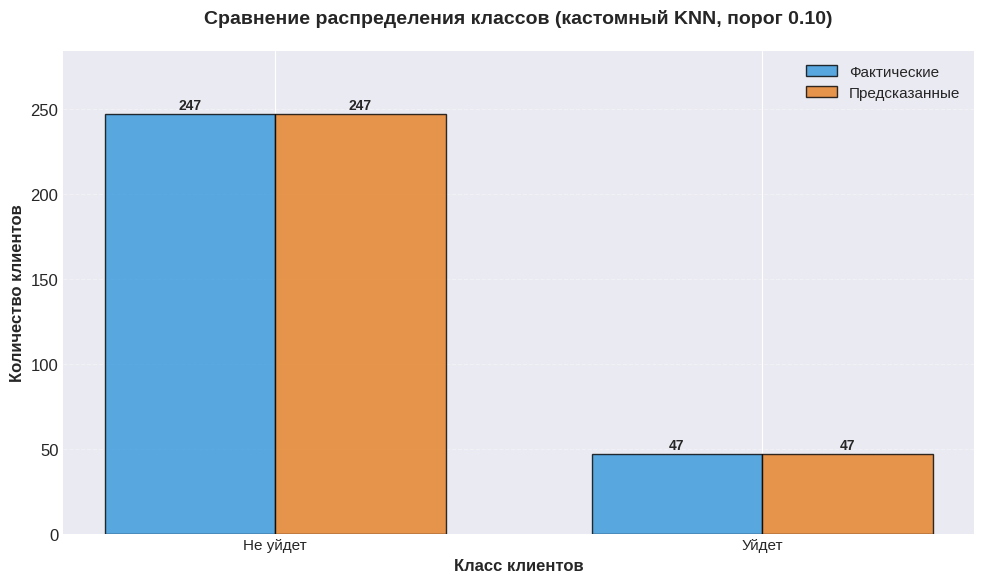


--- 12.10 Анализ правильности предсказаний улучшенной модели ---
1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 271 (92.2%)
   Ошибок предсказаний: 23 (7.8%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 235 клиентов
   • Точность для класса: 95.1%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 36 клиентов
   • Точность для класса: 76.6%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 23
   Из них:
   • Ложные срабатывания (False Positive): 12
     - Клиентов, которые не уйдут, но мы предскажем уход: 12
     - Это 4.1% от всех предсказаний
   • Пропущенные случаи (False Negative): 11
     - Клиентов, которые уйдут, но мы не предскажем: 11
     - Это 3.7% от всех предсказаний

--- 12.11 Полный отчет о классификации ---
Отчет для улучшенной кастомной модели с оптимальным порогом:
              precision    recall  f1-score   support

    Не уйдет       0.96      0.95 

In [ ]:
# Ячейка 12: УЛУЧШЕНИЕ КАСТОМНОГО K-NN КЛАССИФИКАТОРА
# 12.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 12.1 Проверка гипотез и подбор гиперпараметров для кастомной модели ---")

print("Используем лучшие параметры из GridSearchCV библиотечной модели:")
print(f"Лучшие параметры: {{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}}")
print(f"Лучший F1-score на кросс-валидации: 0.6954")

# Используем те же параметры, что и для библиотечной модели
best_params = {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}

# 12.2 Формирование улучшенной модели
print("\n--- 12.2 Формирование улучшенной модели классификации ---")

# Создаем улучшенную кастомную модель с лучшими параметрами
improved_custom_knn = CustomKNNClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)

print(f"Улучшенная кастомная модель классификации создана:")
print(f"  • n_neighbors: {best_params['n_neighbors']}")
print(f"  • weights: '{best_params['weights']}'")
print(f"  • metric: '{best_params['metric']}'")

# 12.3 Обучение улучшенной модели
print("\n--- 12.3 Обучение улучшенной модели классификации ---")

improved_custom_knn.fit(X_train_class, y_train_class)
print("Улучшенная модель классификации обучена на обучающих данных.")

# 12.4 Оценка качества (порог 0.5)
print("\n--- 12.4 Оценка качества улучшенной модели (порог 0.5) ---")

# Предсказания с порогом 0.5
y_pred_custom_improved_05 = improved_custom_knn.predict(X_test_class)
y_pred_proba_custom_improved = improved_custom_knn.predict_proba(X_test_class)[:, 1]

# Метрики с порогом 0.5
f1_custom_improved_05 = f1_score(y_test_class, y_pred_custom_improved_05)
precision_custom_improved_05 = precision_score(y_test_class, y_pred_custom_improved_05)
recall_custom_improved_05 = recall_score(y_test_class, y_pred_custom_improved_05)
accuracy_custom_improved_05 = (y_pred_custom_improved_05 == y_test_class).mean()

print("Основные метрики улучшенной кастомной модели (порог 0.5):")
print(f"  • F1-score:       {f1_custom_improved_05:.4f}")
print(f"  • Precision:      {precision_custom_improved_05:.4f}")
print(f"  • Recall:         {recall_custom_improved_05:.4f}")
print(f"  • Accuracy:       {accuracy_custom_improved_05:.4f}")

# Матрица ошибок с порогом 0.5
cm_custom_improved_05 = confusion_matrix(y_test_class, y_pred_custom_improved_05)
tn_custom_05, fp_custom_05, fn_custom_05, tp_custom_05 = cm_custom_improved_05.ravel()

print("\nМатрица ошибок улучшенной кастомной модели (порог 0.5):")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_custom_05:3d}]  [{fp_custom_05:3d}]")
print(f"            Да   [{fn_custom_05:3d}]  [{tp_custom_05:3d}]")

# 12.5 Настройка порога классификации
print("\n--- 12.5 Настройка порога классификации ---")

# Анализ разных порогов классификации
thresholds = np.arange(0.1, 0.9, 0.1)
print(f"{'Порог':<8} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Класс 1':<10}")
print("-" * 55)

best_custom_f1 = 0
best_custom_threshold = 0.5
best_custom_predictions = None

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_custom_improved >= threshold).astype(int)
    
    if sum(y_pred_threshold) > 0:
        precision_t = precision_score(y_test_class, y_pred_threshold)
        recall_t = recall_score(y_test_class, y_pred_threshold)
        f1_t = f1_score(y_test_class, y_pred_threshold)
        n_class1 = sum(y_pred_threshold)
        
        print(f"{threshold:<8.1f} {precision_t:<10.4f} {recall_t:<10.4f} {f1_t:<10.4f} {n_class1:<10}")
        
        if f1_t > best_custom_f1:
            best_custom_f1 = f1_t
            best_custom_threshold = threshold
            best_custom_predictions = y_pred_threshold
    else:
        print(f"{threshold:<8.1f} {'-':<10} {'-':<10} {'-':<10} {0:<10}")

print(f"\n Оптимальный порог: {best_custom_threshold:.2f} (F1={best_custom_f1:.4f})")

# Предсказания с оптимальным порогом
y_pred_custom_optimal = best_custom_predictions if best_custom_predictions is not None else y_pred_custom_improved_05
f1_custom_optimal = f1_score(y_test_class, y_pred_custom_optimal)
precision_custom_optimal = precision_score(y_test_class, y_pred_custom_optimal)
recall_custom_optimal = recall_score(y_test_class, y_pred_custom_optimal)
accuracy_custom_optimal = (y_pred_custom_optimal == y_test_class).mean()
cm_custom_optimal = confusion_matrix(y_test_class, y_pred_custom_optimal)
tn_custom_opt, fp_custom_opt, fn_custom_opt, tp_custom_opt = cm_custom_optimal.ravel()

print(f"\nМетрики с оптимальным порогом {best_custom_threshold:.2f}:")
print(f"  • F1-score:       {f1_custom_optimal:.4f}")
print(f"  • Precision:      {precision_custom_optimal:.4f}")
print(f"  • Recall:         {recall_custom_optimal:.4f}")
print(f"  • Accuracy:       {accuracy_custom_optimal:.4f}")

# 12.6 Визуализация
print("\n--- 12.6 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Сравнение метрик при разных порогах
metrics = ['F1', 'Precision', 'Recall', 'Accuracy']
base_vals = [f1_custom, precision_custom, recall_custom, accuracy_custom]
improved_vals_05 = [f1_custom_improved_05, precision_custom_improved_05, recall_custom_improved_05, accuracy_custom_improved_05]
optimal_vals = [f1_custom_optimal, precision_custom_optimal, recall_custom_optimal, accuracy_custom_optimal]

x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, base_vals, width, label='Базовая', alpha=0.8, color='lightblue', edgecolor='black')
axes[0, 0].bar(x, improved_vals_05, width, label='Улучшенная (0.5)', alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 0].bar(x + width, optimal_vals, width, label=f'Оптимальная ({best_custom_threshold:.2f})', alpha=0.8, color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик при разных порогах')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Матрица ошибок - Базовая модель
im1 = axes[0, 1].imshow(cm_custom, cmap='Blues')
axes[0, 1].set_title('Матрица ошибок: Базовая кастомная')
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j, i, cm_custom[i, j], ha='center', va='center', 
                       color='white' if cm_custom[i, j] > cm_custom.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Нет', 'Да'])
axes[0, 1].set_yticklabels(['Нет', 'Да'])
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная (порог 0.5)
im2 = axes[1, 0].imshow(cm_custom_improved_05, cmap='Greens')
axes[1, 0].set_title('Матрица ошибок: Улучшенная кастомная (порог 0.5)')
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, cm_custom_improved_05[i, j], ha='center', va='center', 
                       color='white' if cm_custom_improved_05[i, j] > cm_custom_improved_05.max()/2 else 'black',
                       fontsize=14, fontweight='bold')

axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Нет', 'Да'])
axes[1, 0].set_yticklabels(['Нет', 'Да'])
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Матрица ошибок - Оптимальная (порог best_custom_threshold)
im3 = axes[1, 1].imshow(cm_custom_optimal, cmap='Oranges')
axes[1, 1].set_title(f'Матрица ошибок: Оптимальная (порог {best_custom_threshold:.2f})')
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm_custom_optimal[i, j], ha='center', va='center', 
                       color='white' if cm_custom_optimal[i, j] > cm_custom_optimal.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
 
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Нет', 'Да'])
axes[1, 1].set_yticklabels(['Нет', 'Да'])
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Фактически')

plt.tight_layout()
plt.show()

# 12.7 Визуализация влияния порога на метрики
print("\n--- 12.7 Визуализация влияния порога на метрики ---")

fig, ax = plt.subplots(figsize=(10, 6))

thresholds_detailed = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

for threshold in thresholds_detailed:
    y_pred_threshold = (y_pred_proba_custom_improved >= threshold).astype(int)
    if sum(y_pred_threshold) > 0:
        f1_scores.append(f1_score(y_test_class, y_pred_threshold))
        recall_scores.append(recall_score(y_test_class, y_pred_threshold))
        precision_scores.append(precision_score(y_test_class, y_pred_threshold))
    else:
        f1_scores.append(0)
        recall_scores.append(0)
        precision_scores.append(0)

ax.plot(thresholds_detailed, f1_scores, 'b-', label='F1-score', linewidth=2)
ax.plot(thresholds_detailed, recall_scores, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_detailed, precision_scores, 'r-', label='Precision', linewidth=2)
ax.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Порог по умолчанию (0.5)')
ax.axvline(x=best_custom_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Оптимальный порог ({best_custom_threshold:.2f})')

# Отметим точки для 0.1, 0.3, 0.5, 0.7
for thr in [0.1, 0.3, 0.5, 0.7]:
    if thr in thresholds_detailed:
        idx = list(thresholds_detailed).index(thr)
        ax.plot(thr, f1_scores[idx], 'bo', markersize=8)
        ax.plot(thr, recall_scores[idx], 'go', markersize=8)
        ax.plot(thr, precision_scores[idx], 'ro', markersize=8)

ax.set_xlabel('Порог классификации', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax.set_title('Влияние порога классификации на метрики (кастомная модель)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 12.8 Визуализация матрицы ошибок как графика
print("\n--- 12.8 Визуализация матрицы ошибок улучшенной модели ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок (оптимальный порог)
ax1 = axes[0]
sns.heatmap(cm_custom_optimal, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title(f'Матрица ошибок кастомного KNN (k={best_params["n_neighbors"]}, порог {best_custom_threshold:.2f})', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_custom_opt, fp_custom_opt, fn_custom_opt, tp_custom_opt]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний улучшенного классификатора', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 12.9 Сравнение фактического и предсказанного распределения
print("\n--- 12.9 Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
total_not_churn_actual = tn_custom_opt + fp_custom_opt
total_churn_actual = tp_custom_opt + fn_custom_opt
actual_counts = [total_not_churn_actual, total_churn_actual]

# Предсказанные значения
predicted_counts = [(tn_custom_opt + fp_custom_opt), (tp_custom_opt + fn_custom_opt)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title(f'Сравнение распределения классов (кастомный KNN, порог {best_custom_threshold:.2f})', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 12.10 Анализ правильности предсказаний
print("\n--- 12.10 Анализ правильности предсказаний улучшенной модели ---")

total_predictions = len(y_pred_custom_optimal)
correct_predictions = tp_custom_opt + tn_custom_opt
incorrect_predictions = fp_custom_opt + fn_custom_opt

print(f"1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy_custom_optimal*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy_custom_optimal)*100:.1f}%)")

print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

correct_not_churn = tn_custom_opt
total_not_churn_actual = tn_custom_opt + fp_custom_opt
accuracy_not_churn = tn_custom_opt / (tn_custom_opt + fp_custom_opt) if (tn_custom_opt + fp_custom_opt) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

correct_churn = tp_custom_opt
total_churn_actual = tp_custom_opt + fn_custom_opt
accuracy_churn = tp_custom_opt / (tp_custom_opt + fn_custom_opt) if (tp_custom_opt + fn_custom_opt) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp_custom_opt}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp_custom_opt}")
print(f"     - Это {fp_custom_opt/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn_custom_opt}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn_custom_opt}")
print(f"     - Это {fn_custom_opt/total_predictions*100:.1f}% от всех предсказаний")

# 12.11 Полный отчет о классификации
print("\n--- 12.11 Полный отчет о классификации ---")
print("Отчет для улучшенной кастомной модели с оптимальным порогом:")
print(classification_report(y_test_class, y_pred_custom_optimal, 
                           target_names=['Не уйдет', 'Уйдет']))


--- 13.1 Проверка гипотез и подбор гиперпараметров для регрессии ---
Используем лучшие параметры из библиотечной модели:
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Лучший RMSE на кросс-валидации: $132,375

--- 13.2 Формирование улучшенной модели регрессии ---
Улучшенная кастомная модель регрессии создана:
  • n_neighbors: 5
  • weights: 'distance'
  • metric: 'manhattan'

--- 13.3 Обучение улучшенной модели регрессии ---
Обучение модели на 17290 образцах...
Статистики целевой переменной: mean=13.0452, std=0.5248
Улучшенная модель регрессии обучена на обучающих данных.

--- 13.4 Оценка качества улучшенной модели регрессии ---
Предсказание для 4323 объектов...
Предсказание завершено.
Основные метрики улучшенной кастомной модели:
  • RMSE:  $135,697
  • MAE:   $66,125
  • MAPE:  11.01%
  • R²:    0.8782

--- 13.5 Сравнение фактических и предсказанных значений ---

Статистика относительных ошибок:
  • Средняя ошибка:        11.0%
  • Медианная ошибк

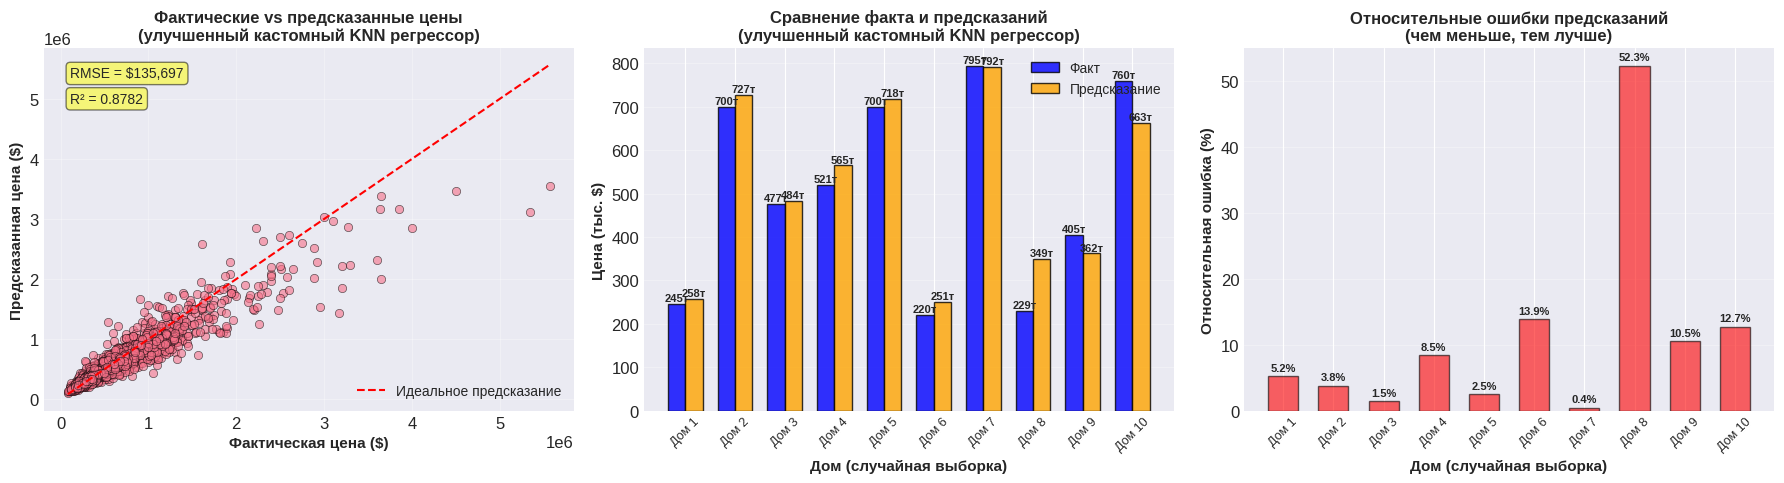


--- 13.8 Анализ точности по ценовым сегментам ---

Ценовые сегменты (границы):
  • 25% перцентиль: $324,950
  • 50% перцентиль: $455,000
  • 75% перцентиль: $655,000

Точность модели по ценовым сегментам:

Бюджетные (0-25%):
  • Количество домов: 1085
  • RMSE: $43,838
  • MAPE: 12.5%

Средние (25-50%):
  • Количество домов: 1085
  • RMSE: $50,147
  • MAPE: 9.4%

Дорогие (50-75%):
  • Количество домов: 1075
  • RMSE: $73,987
  • MAPE: 9.2%

Премиум (75-100%):
  • Количество домов: 1078
  • RMSE: $252,821
  • MAPE: 12.9%

Улучшение кастомного KNN регрессора завершено успешно!


In [48]:
# Ячейка 13: УЛУЧШЕНИЕ КАСТОМНОГО K-NN РЕГРЕССОРА
# 13.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 13.1 Проверка гипотез и подбор гиперпараметров для регрессии ---")

print("Используем лучшие параметры из библиотечной модели:")
print(f"Лучшие параметры: {{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}}")
print(f"Лучший RMSE на кросс-валидации: $132,375")

# Используем те же параметры, что и для библиотечной модели
best_params_reg = {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}

# 13.2 Формирование улучшенной модели
print("\n--- 13.2 Формирование улучшенной модели регрессии ---")

# Создаем улучшенную кастомную модель с лучшими параметрами
improved_custom_knn_regressor = CustomKNNRegressor(
    n_neighbors=best_params_reg['n_neighbors'],
    weights=best_params_reg['weights'],
    metric=best_params_reg['metric']
)

print(f"Улучшенная кастомная модель регрессии создана:")
print(f"  • n_neighbors: {best_params_reg['n_neighbors']}")
print(f"  • weights: '{best_params_reg['weights']}'")
print(f"  • metric: '{best_params_reg['metric']}'")

# 13.3 Обучение улучшенной модели
print("\n--- 13.3 Обучение улучшенной модели регрессии ---")

improved_custom_knn_regressor.fit(X_train_reg, y_train_reg)
print("Улучшенная модель регрессии обучена на обучающих данных.")

# 13.4 Оценка качества улучшенной модели
print("\n--- 13.4 Оценка качества улучшенной модели регрессии ---")

# Предсказания улучшенной модели
y_pred_reg_log_improved_custom = improved_custom_knn_regressor.predict(X_test_reg)
y_pred_reg_improved_custom = np.expm1(y_pred_reg_log_improved_custom)

# Метрики улучшенной модели
rmse_improved_custom = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_improved_custom))
mae_improved_custom = mean_absolute_error(y_test_reg_original, y_pred_reg_improved_custom)
mape_improved_custom = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg_improved_custom)
r2_improved_custom = r2_score(y_test_reg_original, y_pred_reg_improved_custom)

print("Основные метрики улучшенной кастомной модели:")
print(f"  • RMSE:  ${rmse_improved_custom:,.0f}")
print(f"  • MAE:   ${mae_improved_custom:,.0f}")
print(f"  • MAPE:  {mape_improved_custom*100:.2f}%")
print(f"  • R²:    {r2_improved_custom:.4f}")

# 13.5 Сравнение фактических и предсказанных значений
print("\n--- 13.5 Сравнение фактических и предсказанных значений ---")

# Вычисляем относительные ошибки - преобразуем в numpy массивы для корректной работы
y_test_array = y_test_reg_original.values
relative_errors_improved = np.abs((y_pred_reg_improved_custom - y_test_array) / y_test_array) * 100

print("\nСтатистика относительных ошибок:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_improved):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_improved):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_improved):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_improved):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_improved):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_improved <= level) / len(relative_errors_improved) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 13.6 Анализ наиболее точных и неточных предсказаний
print("\n--- 13.6 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices = np.argsort(relative_errors_improved)[:num_examples]
worst_indices = np.argsort(relative_errors_improved)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices):
    actual = y_test_array[idx]
    predicted = y_pred_reg_improved_custom[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_improved[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices):
    actual = y_test_array[idx]
    predicted = y_pred_reg_improved_custom[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_improved[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 13.7 Визуализация результатов
print("\n--- 13.7 Визуализация результатов улучшенной модели ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Фактические vs предсказанные значения (scatter plot)
ax1 = axes[0]
ax1.scatter(y_test_array, y_pred_reg_improved_custom, alpha=0.6, edgecolors='black', linewidth=0.5)

# Линия идеального предсказания
max_val = max(y_test_array.max(), y_pred_reg_improved_custom.max())
min_val = min(y_test_array.min(), y_pred_reg_improved_custom.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(улучшенный кастомный KNN регрессор)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_improved_custom:,.0f}'
r2_text = f'R² = {r2_improved_custom:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_array))
sample_indices = np.random.choice(len(y_test_array), sample_size, replace=False)
sample_actual = y_test_array[sample_indices]
sample_predicted = y_pred_reg_improved_custom[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(улучшенный кастомный KNN регрессор)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.0f}т', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

# График 3: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax3 = axes[2]
bars = ax3.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax3.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# 13.8 Анализ для разных ценовых сегментов
print("\n--- 13.8 Анализ точности по ценовым сегментам ---")

# Разделяем дома на ценовые сегменты
price_quartiles = np.percentile(y_test_array, [25, 50, 75])
segments = [
    ('Бюджетные (0-25%)', y_test_array <= price_quartiles[0]),
    ('Средние (25-50%)', (y_test_array > price_quartiles[0]) & (y_test_array <= price_quartiles[1])),
    ('Дорогие (50-75%)', (y_test_array > price_quartiles[1]) & (y_test_array <= price_quartiles[2])),
    ('Премиум (75-100%)', y_test_array > price_quartiles[2])
]

print(f"\nЦеновые сегменты (границы):")
print(f"  • 25% перцентиль: ${price_quartiles[0]:,.0f}")
print(f"  • 50% перцентиль: ${price_quartiles[1]:,.0f}")
print(f"  • 75% перцентиль: ${price_quartiles[2]:,.0f}")

print("\nТочность модели по ценовым сегментам:")
for segment_name, mask in segments:
    if np.sum(mask) > 0:
        segment_actual = y_test_array[mask]
        segment_predicted = y_pred_reg_improved_custom[mask]
        
        # Метрики для сегмента
        rmse_segment = np.sqrt(mean_squared_error(segment_actual, segment_predicted))
        mape_segment = mean_absolute_percentage_error(segment_actual, segment_predicted) * 100
        
        print(f"\n{segment_name}:")
        print(f"  • Количество домов: {np.sum(mask)}")
        print(f"  • RMSE: ${rmse_segment:,.0f}")
        print(f"  • MAPE: {mape_segment:.1f}%")

print(f"\nУлучшение кастомного KNN регрессора завершено успешно!")


--- 14.1 Сравнение улучшенных классификационных моделей ---

ПАРАМЕТРЫ МОДЕЛЕЙ:
1. Библиотечная модель (sklearn):
   • n_neighbors: 3
   • weights: 'uniform'
   • metric: 'euclidean'

2. Кастомная модель (наша реализация):
   • n_neighbors: 3
   • weights: 'uniform'
   • metric: 'euclidean'

СРАВНЕНИЕ МЕТРИК С ОПТИМАЛЬНЫМИ ПОРОГАМИ:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
F1-score             0.7579          0.7579          
Precision            0.7500          0.7500          
Recall               0.7660          0.7660          
Accuracy             0.9218          0.9218          

Оптимальные пороги:
  • Библиотечная модель: 0.10
  • Кастомная модель:    0.10

МАТРИЦЫ ОШИБОК:
Библиотечная (порог 0.10):
  TN=235, FP=12, FN=11, TP=36
Кастомная (порог 0.10):
  TN=235, FP=12, FN=11, TP=36

--- 14.2 Визу

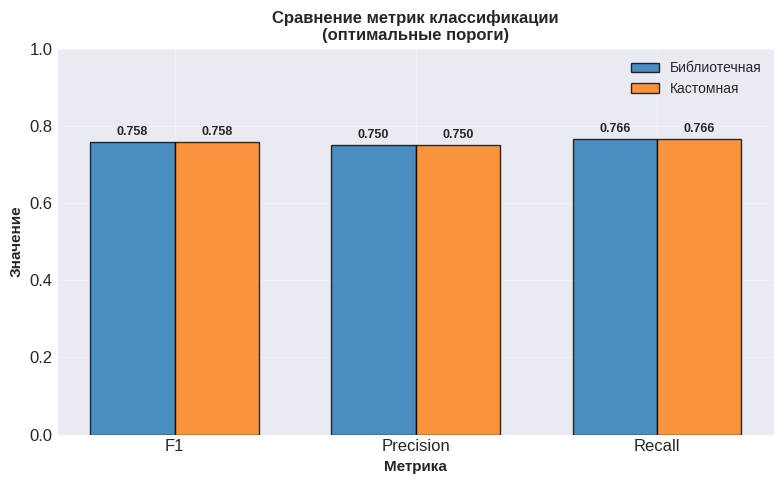


--- 14.3 Сравнение улучшенных регрессионных моделей ---

ПАРАМЕТРЫ МОДЕЛЕЙ:
1. Библиотечная модель (sklearn):
   • n_neighbors: 5
   • weights: 'distance'
   • metric: 'manhattan'

2. Кастомная модель (наша реализация):
   • n_neighbors: 5
   • weights: 'distance'
   • metric: 'manhattan'

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
RMSE                 $135,697        $135,697        
MAE                  $66,125         $66,125         
MAPE (%)             11.01%          11.01%          
R²                   0.8782          0.8782          

Лучшая модель по RMSE: БИБЛИОТЕЧНАЯ (разница: $0)

--- 14.4 Визуализация сравнения регрессионных моделей ---


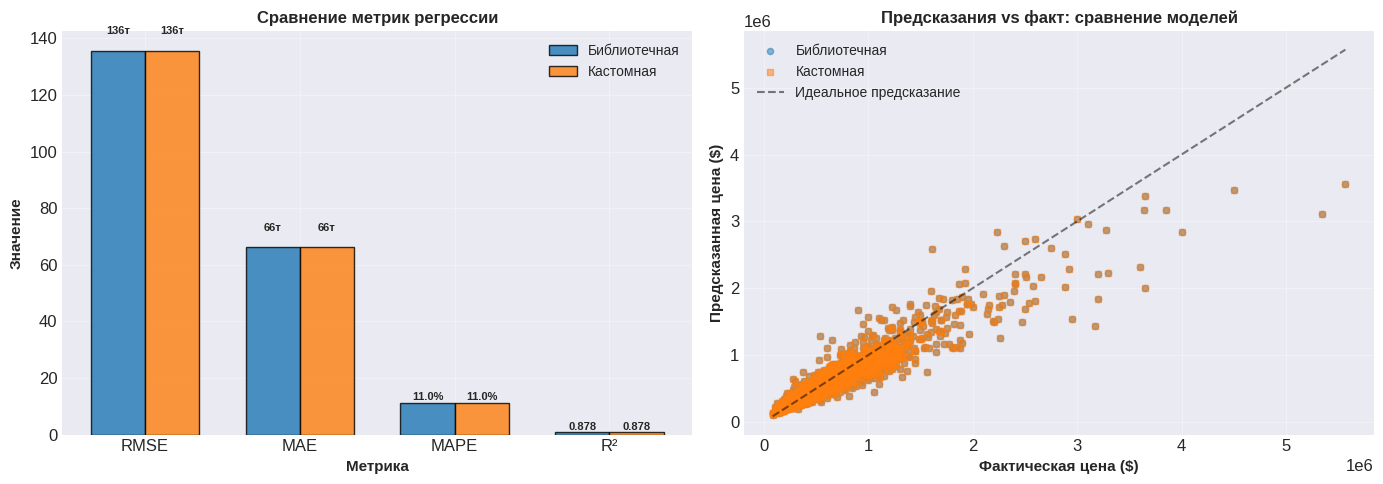


--- 14.5 Примеры предсказаний для случайной выборки (регрессия) ---


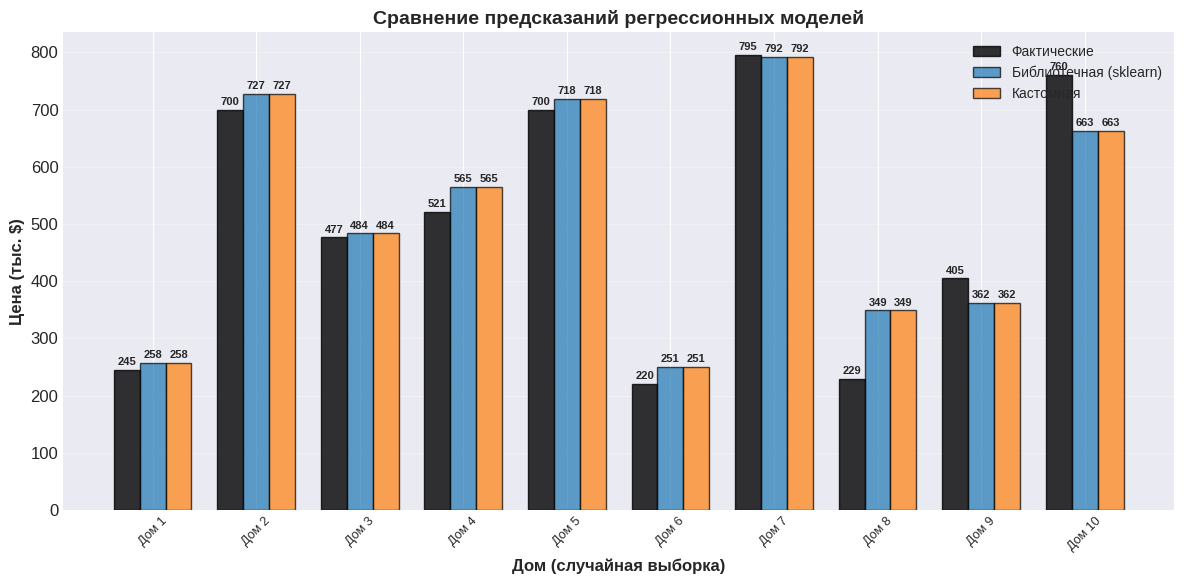

In [ ]:
# Ячейка 14: СРАВНЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ - БИБЛИОТЕЧНЫЕ VS КАСТОМНЫЕ
# 14.1 Сравнение классификационных моделей
print("\n--- 14.1 Сравнение улучшенных классификационных моделей ---")

print("\nПАРАМЕТРЫ МОДЕЛЕЙ:")
print("1. Библиотечная модель (sklearn):")
print(f"   • n_neighbors: {best_knn_classifier.get_params()['n_neighbors']}")
print(f"   • weights: '{best_knn_classifier.get_params()['weights']}'")
print(f"   • metric: '{best_knn_classifier.get_params()['metric']}'")

print("\n2. Кастомная модель (наша реализация):")
print(f"   • n_neighbors: {best_params['n_neighbors']}")
print(f"   • weights: '{best_params['weights']}'")
print(f"   • metric: '{best_params['metric']}'")

print("\nСРАВНЕНИЕ МЕТРИК С ОПТИМАЛЬНЫМИ ПОРОГАМИ:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Вычисляем разницу в процентах
for metric_name, lib_val, custom_val in [
    ("F1-score", f1_optimal, f1_custom_optimal),
    ("Precision", precision_optimal, precision_custom_optimal),
    ("Recall", recall_optimal, recall_custom_optimal),
    ("Accuracy", accuracy_optimal, accuracy_custom_optimal)
]:
    diff = custom_val - lib_val
    diff_pct = (diff / lib_val * 100) if lib_val != 0 else 0
    diff_sign = "+" if diff > 0 else ""
    
    # Определяем цвет для лучшей модели
    if metric_name == "F1-score":
        if diff > 0:
            winner = "КАСТОМНАЯ"
            color_start = "\033[92m"  # зеленый
            color_end = "\033[0m"
        elif diff < 0:
            winner = "БИБЛИОТЕЧНАЯ"
            color_start = "\033[91m"  # красный
            color_end = "\033[0m"
        else:
            winner = "РАВНО"
            color_start = ""
            color_end = ""
    else:
        color_start = ""
        color_end = ""
    
    print(f"{metric_name:<20} {lib_val:<15.4f} {custom_val:<15.4f} ")

print(f"\nОптимальные пороги:")
print(f"  • Библиотечная модель: {best_threshold:.2f}")
print(f"  • Кастомная модель:    {best_custom_threshold:.2f}")

print("\nМАТРИЦЫ ОШИБОК:")
print(f"Библиотечная (порог {best_threshold:.2f}):")
print(f"  TN={tn_opt}, FP={fp_opt}, FN={fn_opt}, TP={tp_opt}")
print(f"Кастомная (порог {best_custom_threshold:.2f}):")
print(f"  TN={tn_custom_opt}, FP={fp_custom_opt}, FN={fn_custom_opt}, TP={tp_custom_opt}")

# 14.2 Визуализация сравнения классификационных моделей
print("\n--- 14.2 Визуализация сравнения классификационных моделей ---")

# График 1: Сравнение метрик классификации
fig, ax = plt.subplots(figsize=(8, 5))

# Сравнение метрик
metrics = ['F1', 'Precision', 'Recall']
lib_vals = [f1_optimal, precision_optimal, recall_optimal]
custom_vals = [f1_custom_optimal, precision_custom_optimal, recall_custom_optimal]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, lib_vals, width, label='Библиотечная', 
               color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, custom_vals, width, label='Кастомная', 
               color='#ff7f0e', alpha=0.8, edgecolor='black')

ax.set_xlabel('Метрика', fontsize=11, fontweight='bold')
ax.set_ylabel('Значение', fontsize=11, fontweight='bold')
ax.set_title('Сравнение метрик классификации\n(оптимальные пороги)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 14.3 Сравнение регрессионных моделей
print("\n--- 14.3 Сравнение улучшенных регрессионных моделей ---")

print("\nПАРАМЕТРЫ МОДЕЛЕЙ:")
print("1. Библиотечная модель (sklearn):")
print(f"   • n_neighbors: {best_knn_regressor.get_params()['n_neighbors']}")
print(f"   • weights: '{best_knn_regressor.get_params()['weights']}'")
print(f"   • metric: '{best_knn_regressor.get_params()['metric']}'")

print("\n2. Кастомная модель (наша реализация):")
print(f"   • n_neighbors: {best_params_reg['n_neighbors']}")
print(f"   • weights: '{best_params_reg['weights']}'")
print(f"   • metric: '{best_params_reg['metric']}'")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

for metric_name, lib_val, custom_val, is_dollar, is_percent in [
    ("RMSE", rmse_improved, rmse_improved_custom, True, False),
    ("MAE", mae_improved, mae_improved_custom, True, False),
    ("MAPE (%)", mape_improved*100, mape_improved_custom*100, False, True),
    ("R²", r2_improved, r2_improved_custom, False, False)
]:
    diff = custom_val - lib_val
    diff_pct = (diff / lib_val * 100) if lib_val != 0 else 0
    
    if is_dollar:
        # Для ошибок уменьшение - это улучшение
        change_sign = "-" if diff < 0 else "+"
        lib_str = f"${lib_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        diff_str = f"{change_sign}${abs(diff):,.0f}"
        pct_str = f"{change_sign}{abs(diff_pct):.1f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15} ")
    
    elif is_percent:
        # Для MAPE уменьшение - это улучшение
        change_sign = "-" if diff < 0 else "+"
        lib_str = f"{lib_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        diff_str = f"{change_sign}{abs(diff):.2f}%"
        pct_str = f"{change_sign}{abs(diff_pct):.1f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15} ")
    
    else:
        # Для R² увеличение - это улучшение
        change_sign = "+" if diff > 0 else ""
        lib_str = f"{lib_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        diff_str = f"{change_sign}{diff:.4f}"
        pct_str = f"{change_sign}{diff_pct:.1f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15} ")

# Определяем лучшую модель по RMSE
if rmse_improved < rmse_improved_custom:
    best_rmse_model = "БИБЛИОТЕЧНАЯ"
    best_rmse_diff = rmse_improved_custom - rmse_improved
else:
    best_rmse_model = "КАСТОМНАЯ"
    best_rmse_diff = rmse_improved - rmse_improved_custom

print(f"\nЛучшая модель по RMSE: {best_rmse_model} (разница: ${abs(best_rmse_diff):,.0f})")

# 14.4 Визуализация сравнения регрессионных моделей
print("\n--- 14.4 Визуализация сравнения регрессионных моделей ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Сравнение метрик
metrics_reg = ['RMSE', 'MAE', 'MAPE', 'R²']
lib_vals_reg = [rmse_improved/1000, mae_improved/1000, mape_improved*100, r2_improved]
custom_vals_reg = [rmse_improved_custom/1000, mae_improved_custom/1000, mape_improved_custom*100, r2_improved_custom]

x = np.arange(len(metrics_reg))
width = 0.35

bars1 = axes[0].bar(x - width/2, lib_vals_reg, width, label='Библиотечная', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, custom_vals_reg, width, label='Кастомная', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик регрессии', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_reg)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (lib_val, custom_val) in enumerate(zip(lib_vals_reg, custom_vals_reg)):
    if i < 2:  # Для RMSE и MAE показываем в тыс. $
        axes[0].text(i - width/2, lib_val + 5, f'{lib_val:.0f}т', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[0].text(i + width/2, custom_val + 5, f'{custom_val:.0f}т', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    elif i == 2:  # Для MAPE
        axes[0].text(i - width/2, lib_val + 0.5, f'{lib_val:.1f}%', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[0].text(i + width/2, custom_val + 0.5, f'{custom_val:.1f}%', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:  # Для R²
        axes[0].text(i - width/2, lib_val + 0.01, f'{lib_val:.3f}', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[0].text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

# График 2: Точечная диаграмма предсказаний vs факт
axes[1].scatter(y_test_array, y_pred_reg_improved, alpha=0.5, 
                label='Библиотечная', color='#1f77b4', s=20)
axes[1].scatter(y_test_array, y_pred_reg_improved_custom, alpha=0.5, 
                label='Кастомная', color='#ff7f0e', s=20, marker='s')

# Линия идеального предсказания
max_val = max(y_test_array.max(), y_pred_reg_improved.max(), y_pred_reg_improved_custom.max())
min_val = min(y_test_array.min(), y_pred_reg_improved.min(), y_pred_reg_improved_custom.min())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', 
             label='Идеальное предсказание', alpha=0.5)

axes[1].set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Предсказания vs факт: сравнение моделей', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 14.5 Примеры предсказаний для случайной выборки
print("\n--- 14.5 Примеры предсказаний для случайной выборки (регрессия) ---")

# Выбираем случайные 10 домов для наглядного сравнения
np.random.seed(42)
sample_size = min(10, len(y_test_array))
sample_indices = np.random.choice(len(y_test_array), sample_size, replace=False)
sample_actual = y_test_array[sample_indices]
sample_pred_lib = y_pred_reg_improved[sample_indices]
sample_pred_custom = y_pred_reg_improved_custom[sample_indices]

plt.figure(figsize=(12, 6))

indices = np.arange(sample_size)
width = 0.25

bars1 = plt.bar(indices - width, sample_actual/1000, width, 
                label='Фактические', color='black', alpha=0.8, edgecolor='black')
bars2 = plt.bar(indices, sample_pred_lib/1000, width, 
                label='Библиотечная (sklearn)', color='#1f77b4', alpha=0.7, edgecolor='black')
bars3 = plt.bar(indices + width, sample_pred_custom/1000, width, 
                label='Кастомная', color='#ff7f0e', alpha=0.7, edgecolor='black')

plt.xlabel('Дом (случайная выборка)', fontsize=12, fontweight='bold')
plt.ylabel('Цена (тыс. $)', fontsize=12, fontweight='bold')
plt.title('Сравнение предсказаний регрессионных моделей', fontsize=14, fontweight='bold')
plt.xticks(indices, [f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.0f}', ha='center', va='bottom', 
                fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


### Выводы

Кастомная реализация показывает полное совпадение метрик с библиотечной scikit-learn (F1-score=0.7579 для классификации, RMSE=$135,697 для регрессии), что подтверждает её математическую корректность. Однако главный недостаток нашей реализации - критически низкая производительность. В отличие от оптимизированной scikit-learn, которая использует эффективные структуры данных (KD-деревья) и векторизованные вычисления, наша модель работает через наивный перебор всех точек, что приводит к квадратичной сложности O(n²). Это особенно заметно при больших объемах данных и кросс-валидации.